In [477]:
library(forecast)
library(urca)
library(tseries)
library(zoo)
library(xts)
library(repr)
library(dplyr)
library(ggfortify)
library(astsa)

# Load data

In [478]:
data <- read.table("../VEOLIA/artifacts/timeseries_60min.csv", sep=',', header=TRUE)
y <- data['Diff.Load.Activa.Total..60.minuto.']

# Create time series

In [479]:
start.time <- as.POSIXlt("2020-11-01 00:00:00")
tsdat <- xts(y, seq(start.time, start.time + 20907000, by=3600), frequency=24)

print("Univariate time series created:")
head(as.matrix(tsdat))

[1] "Univariate time series created:"


,Diff.Load.Activa.Total..60.minuto.
2020-11-01 00:00:00,NA
2020-11-01 01:00:00,NA
2020-11-01 01:00:00,NA
2020-11-01 02:00:00,NA
2020-11-01 03:00:00,NA
2020-11-01 04:00:00,NA


# Clean initial zeros
Initial 5 days zero values are cleaned as they are due to lack of mesurements.

In [480]:
j <- tsdat['2020-11-06 11:00:00/']
head(as.matrix(j))
j[is.na(j)]

,Diff.Load.Activa.Total..60.minuto.
2020-11-06 11:00:00,3670
2020-11-06 12:00:00,4240
2020-11-06 13:00:00,3810
2020-11-06 14:00:00,3800
2020-11-06 15:00:00,3820
2020-11-06 16:00:00,3770


     Diff.Load.Activa.Total..60.minuto.

# Statistics

## Time series plot

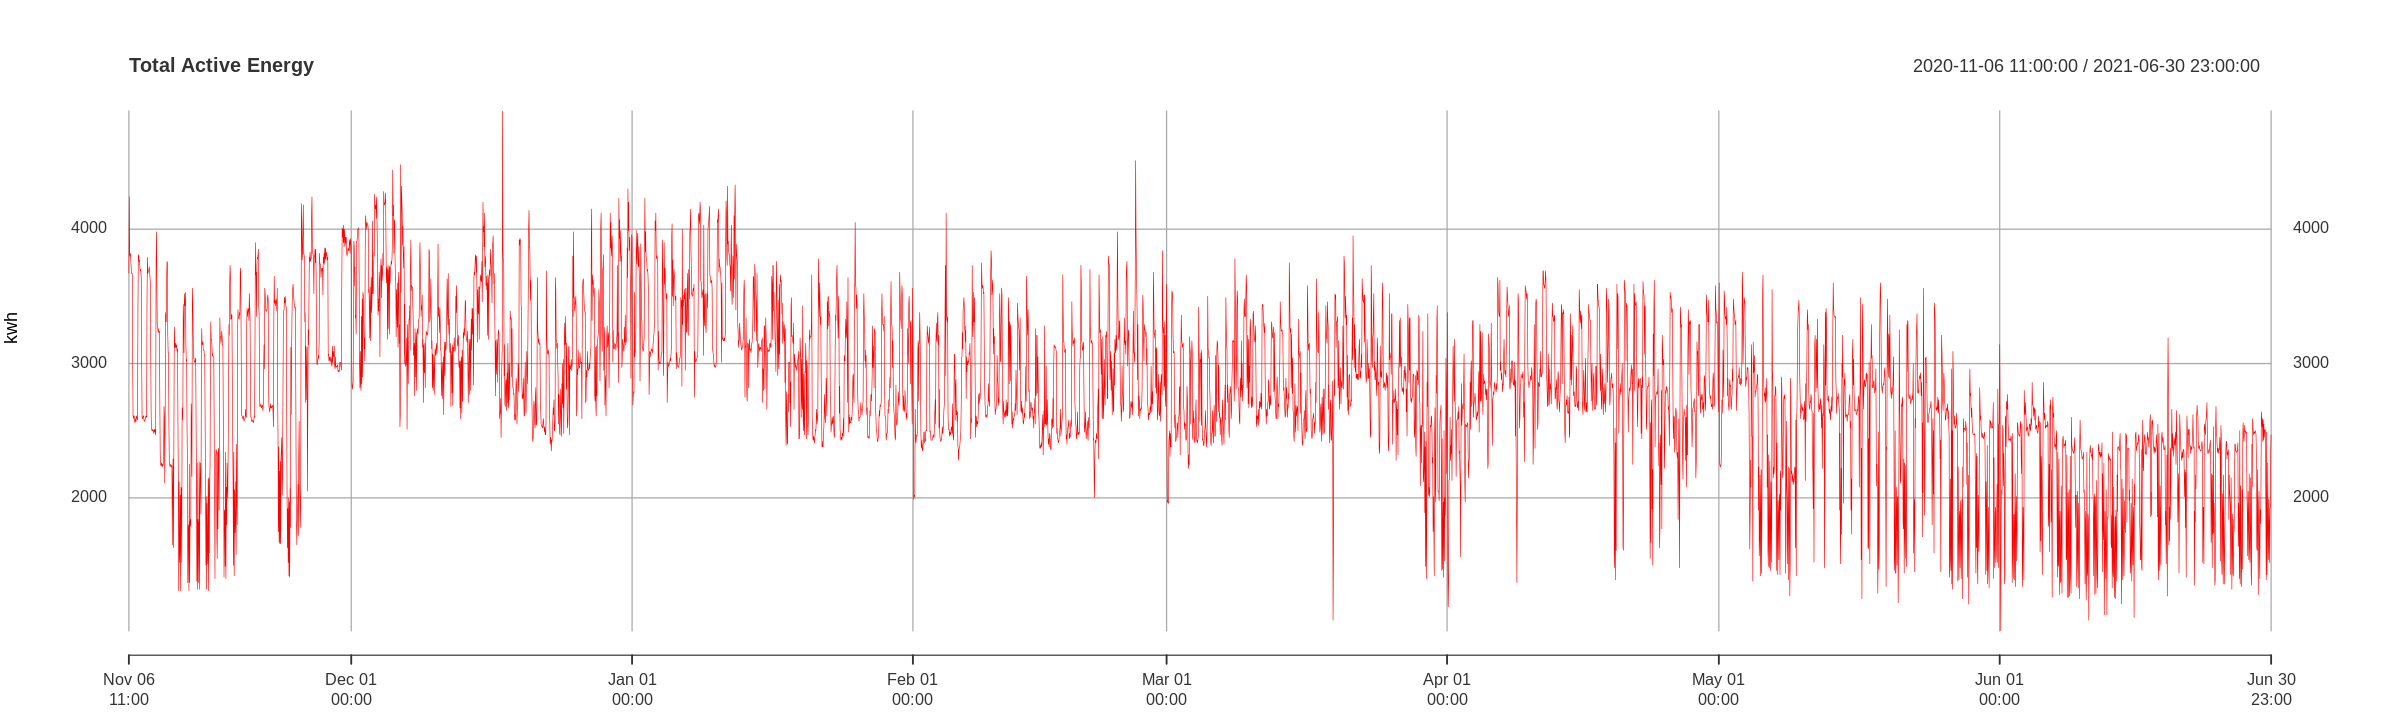

In [481]:
options(repr.plot.width=20, repr.plot.height=6)
plot(j, type="l", col='red', lwd=0.5, main="Total Active Energy", ylab="kwh")

## Outlier handling

2 methods are used to detect outliers (forecast package):
1. tsclean which implements loess decomposition of time series to identify and replace outliers
2. tsoutliers function which implements the Chen and Liu method
Results are exactly the same for both. No outliers are detected at all.

In [482]:
setdiff(tsclean(j)$Diff.Load.Activa.Total..60.minuto., j$Diff.Load.Activa.Total..60.minuto.)

numeric(0)

In [483]:
tsoutliers(j)

$index
integer(0)

$replacements
     Diff.Load.Activa.Total..60.minuto.


## Transforms

In [484]:
dj=diff(j)
lj = log(j)

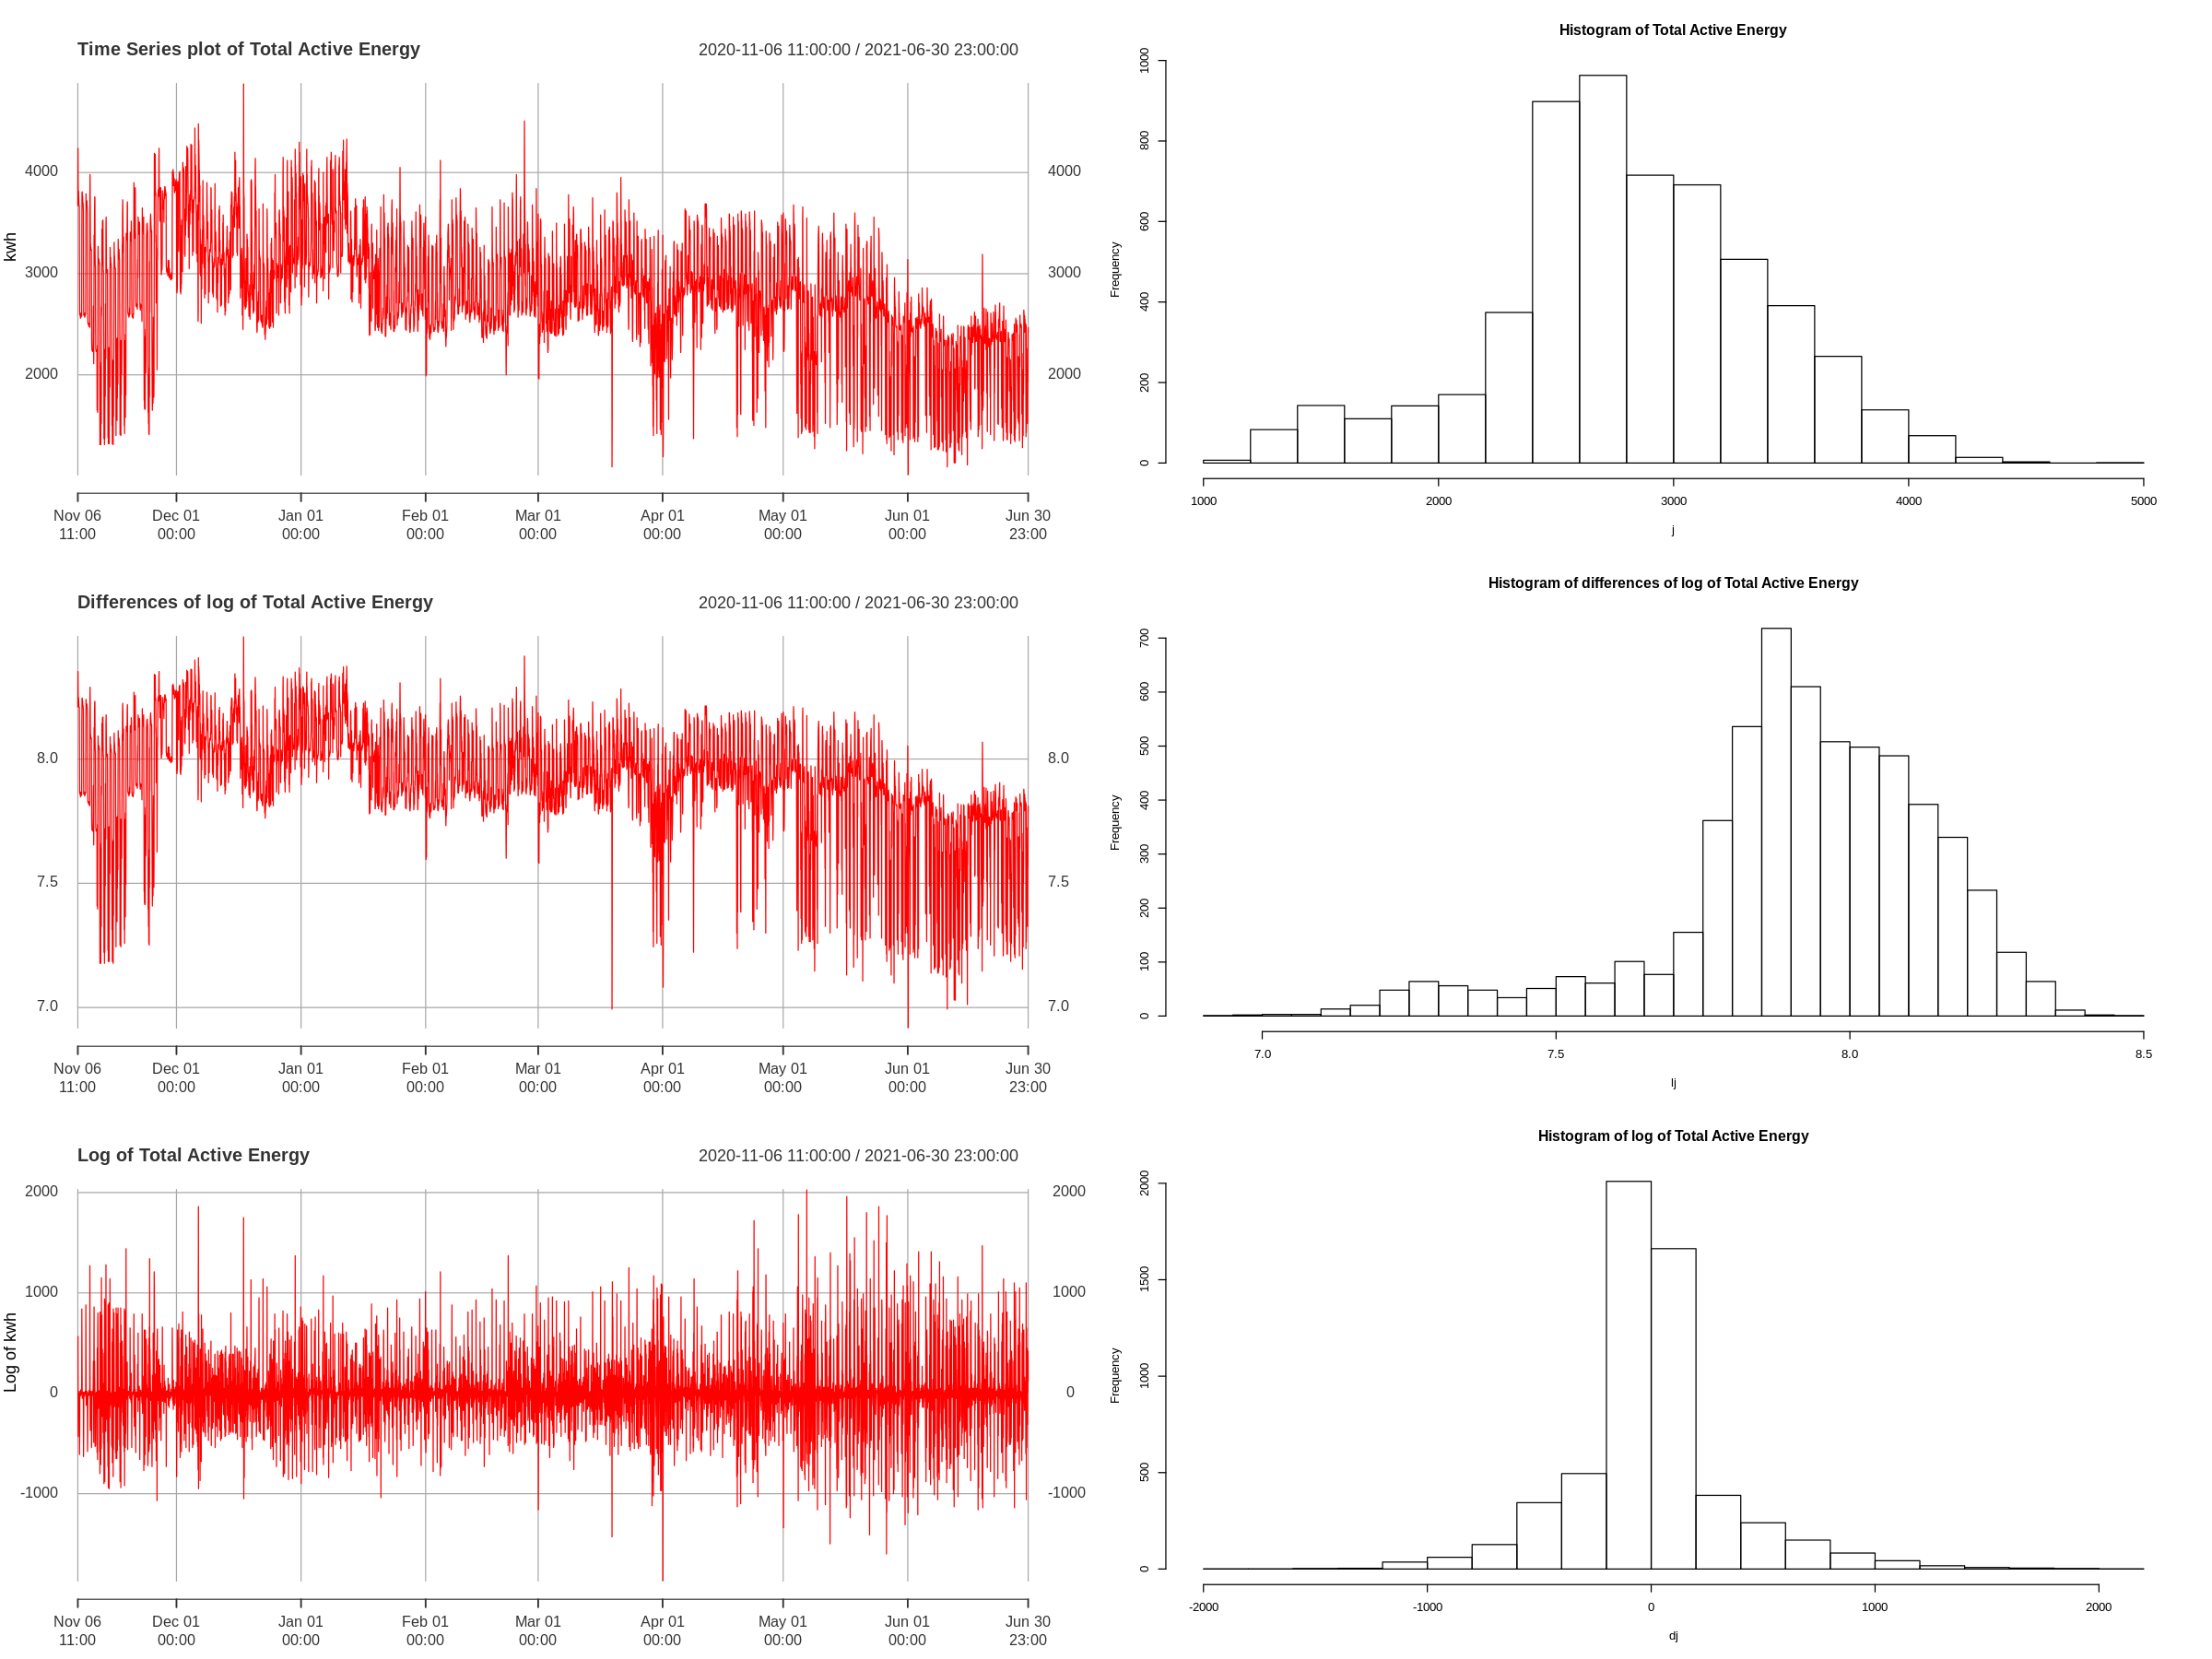

In [485]:
options(repr.plot.width=20, repr.plot.height=15)
par(mfrow=c(3,2)) # set up the graphics
plot(j,type="l", col='red', lwd=1,main="Time Series plot of Total Active Energy", ylab="kwh")
hist(j, nclass=25, main="Histogram of Total Active Energy")
plot(lj,type="l", col='red', lwd=1,main="Differences of log of Total Active Energy")
hist(lj, nclass=25, main="Histogram of differences of log of Total Active Energy")
plot(dj,type="l", col='red', lwd=1,main="Log of Total Active Energy", ylab="Log of kwh")
hist(dj, nclass=25, main="Histogram of log of Total Active Energy")

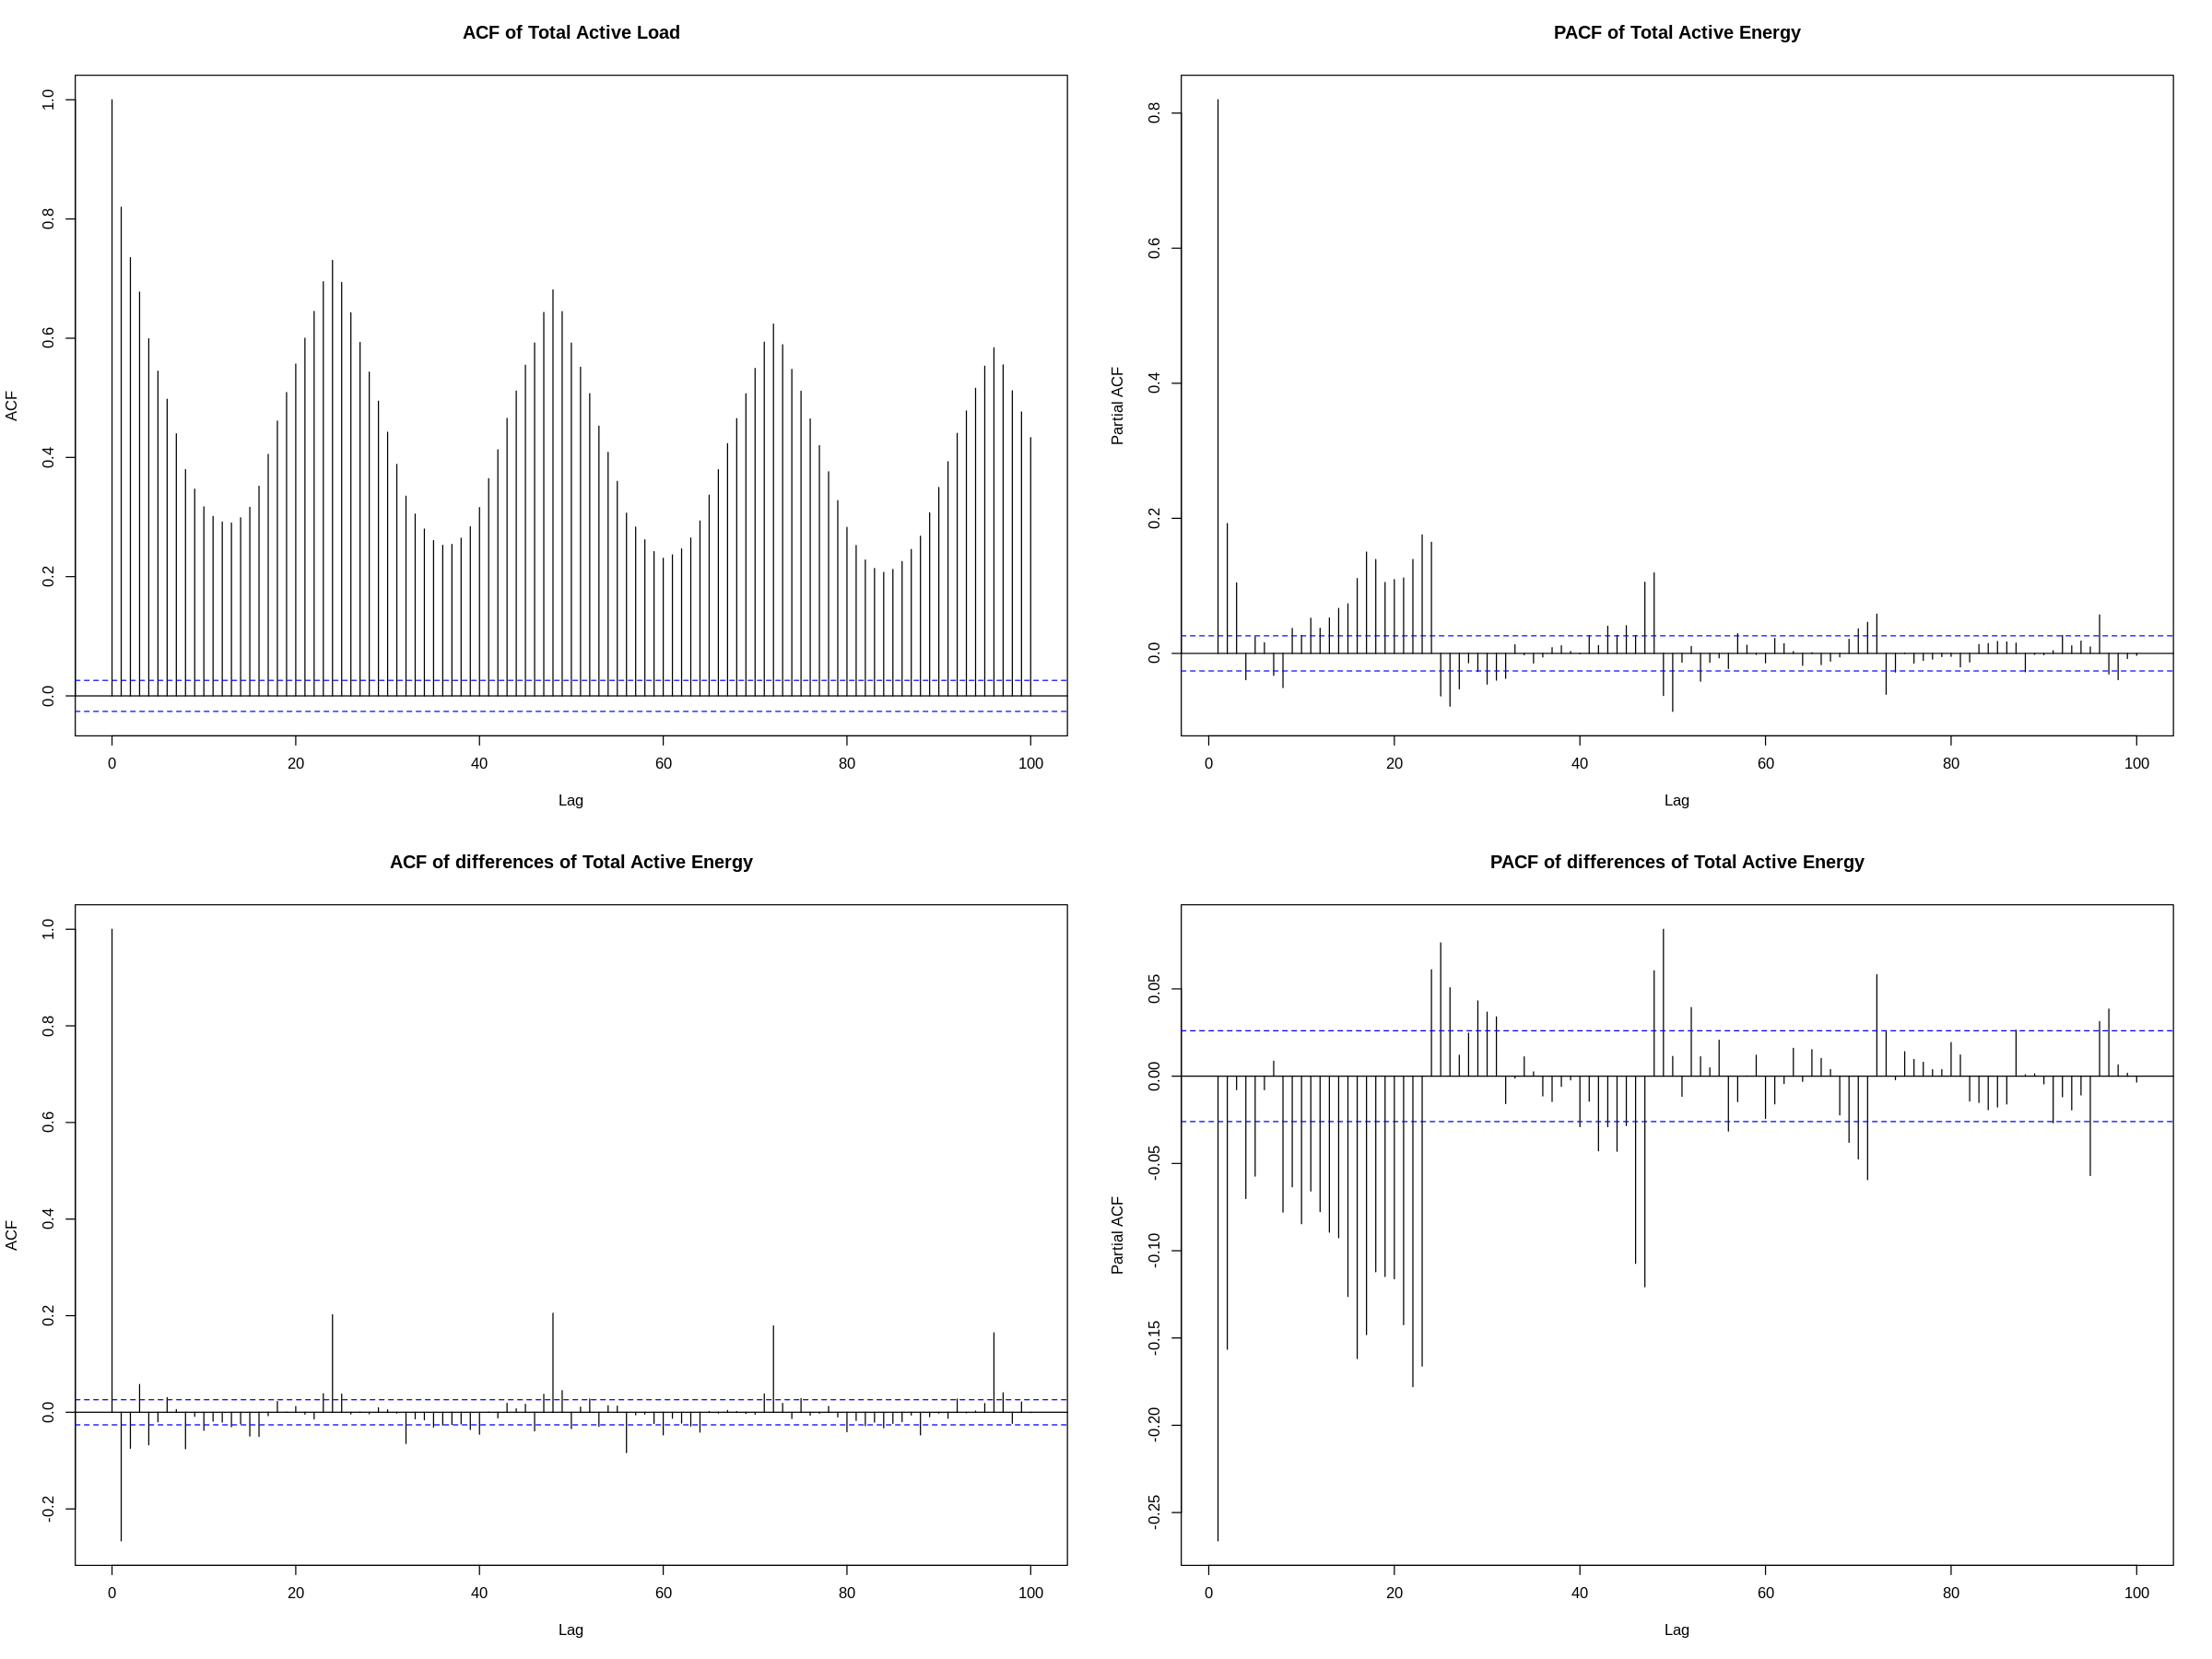

In [486]:
par(mfrow=c(2,2)) # set up the graphics
acf(ts(j, freq=1), 100, main="ACF of Total Active Load") # autocorrelation function plot
pacf(ts(j, freq=1), 100, main="PACF of Total Active Energy") # partial autocorrelation function
acf(ts(dj, freq=1), 100, main="ACF of differences of Total Active Energy", na.action = na.pass)
pacf(ts(dj, freq=1), 100, main="PACF of differences of Total Active Energy", na.action = na.pass)

It is observed that following the diff transformations the time series seems much closer to stationary, effectively removing the trend. This demonstrated the need for on differentiation term. Also skewness of the distribution is mitigated. Heteroskedasticity still appears even in the log transformation and therefore it wont be used further. Seasonal patterns are also observed leading to exploration of decomposition.

## Decomposition
The time series obviously seems to require decomposition

In [487]:
start.time <- as.POSIXlt("2020-11-06 00:00:00")

seasonal <- read.table("../VEOLIA/artifacts/decomposition/TAL_seasonal.csv", sep=',', header=TRUE)
y <- seasonal['seasonal']
seasonal <- xts(y, seq(start.time, start.time + 20475000, by=3600), frequency=24)

trend <- read.table("../VEOLIA/artifacts/decomposition/TAL_trend.csv", sep=',', header=TRUE)
y <- trend['trend']
trend <- xts(y, seq(start.time, start.time + 20475000, by=3600), frequency=24)

resid <- read.table("../VEOLIA/artifacts/decomposition/TAL_resid.csv", sep=',', header=TRUE)
y <- resid['Diff.Load.Activa.Total..60.minuto.']
resid <- xts(y, seq(start.time, start.time + 20475000, by=3600), frequency=24)

### Repeat plots for deseasonalised time series

In [488]:
j2 <- resid + trend
dj2 <- diff(j2)

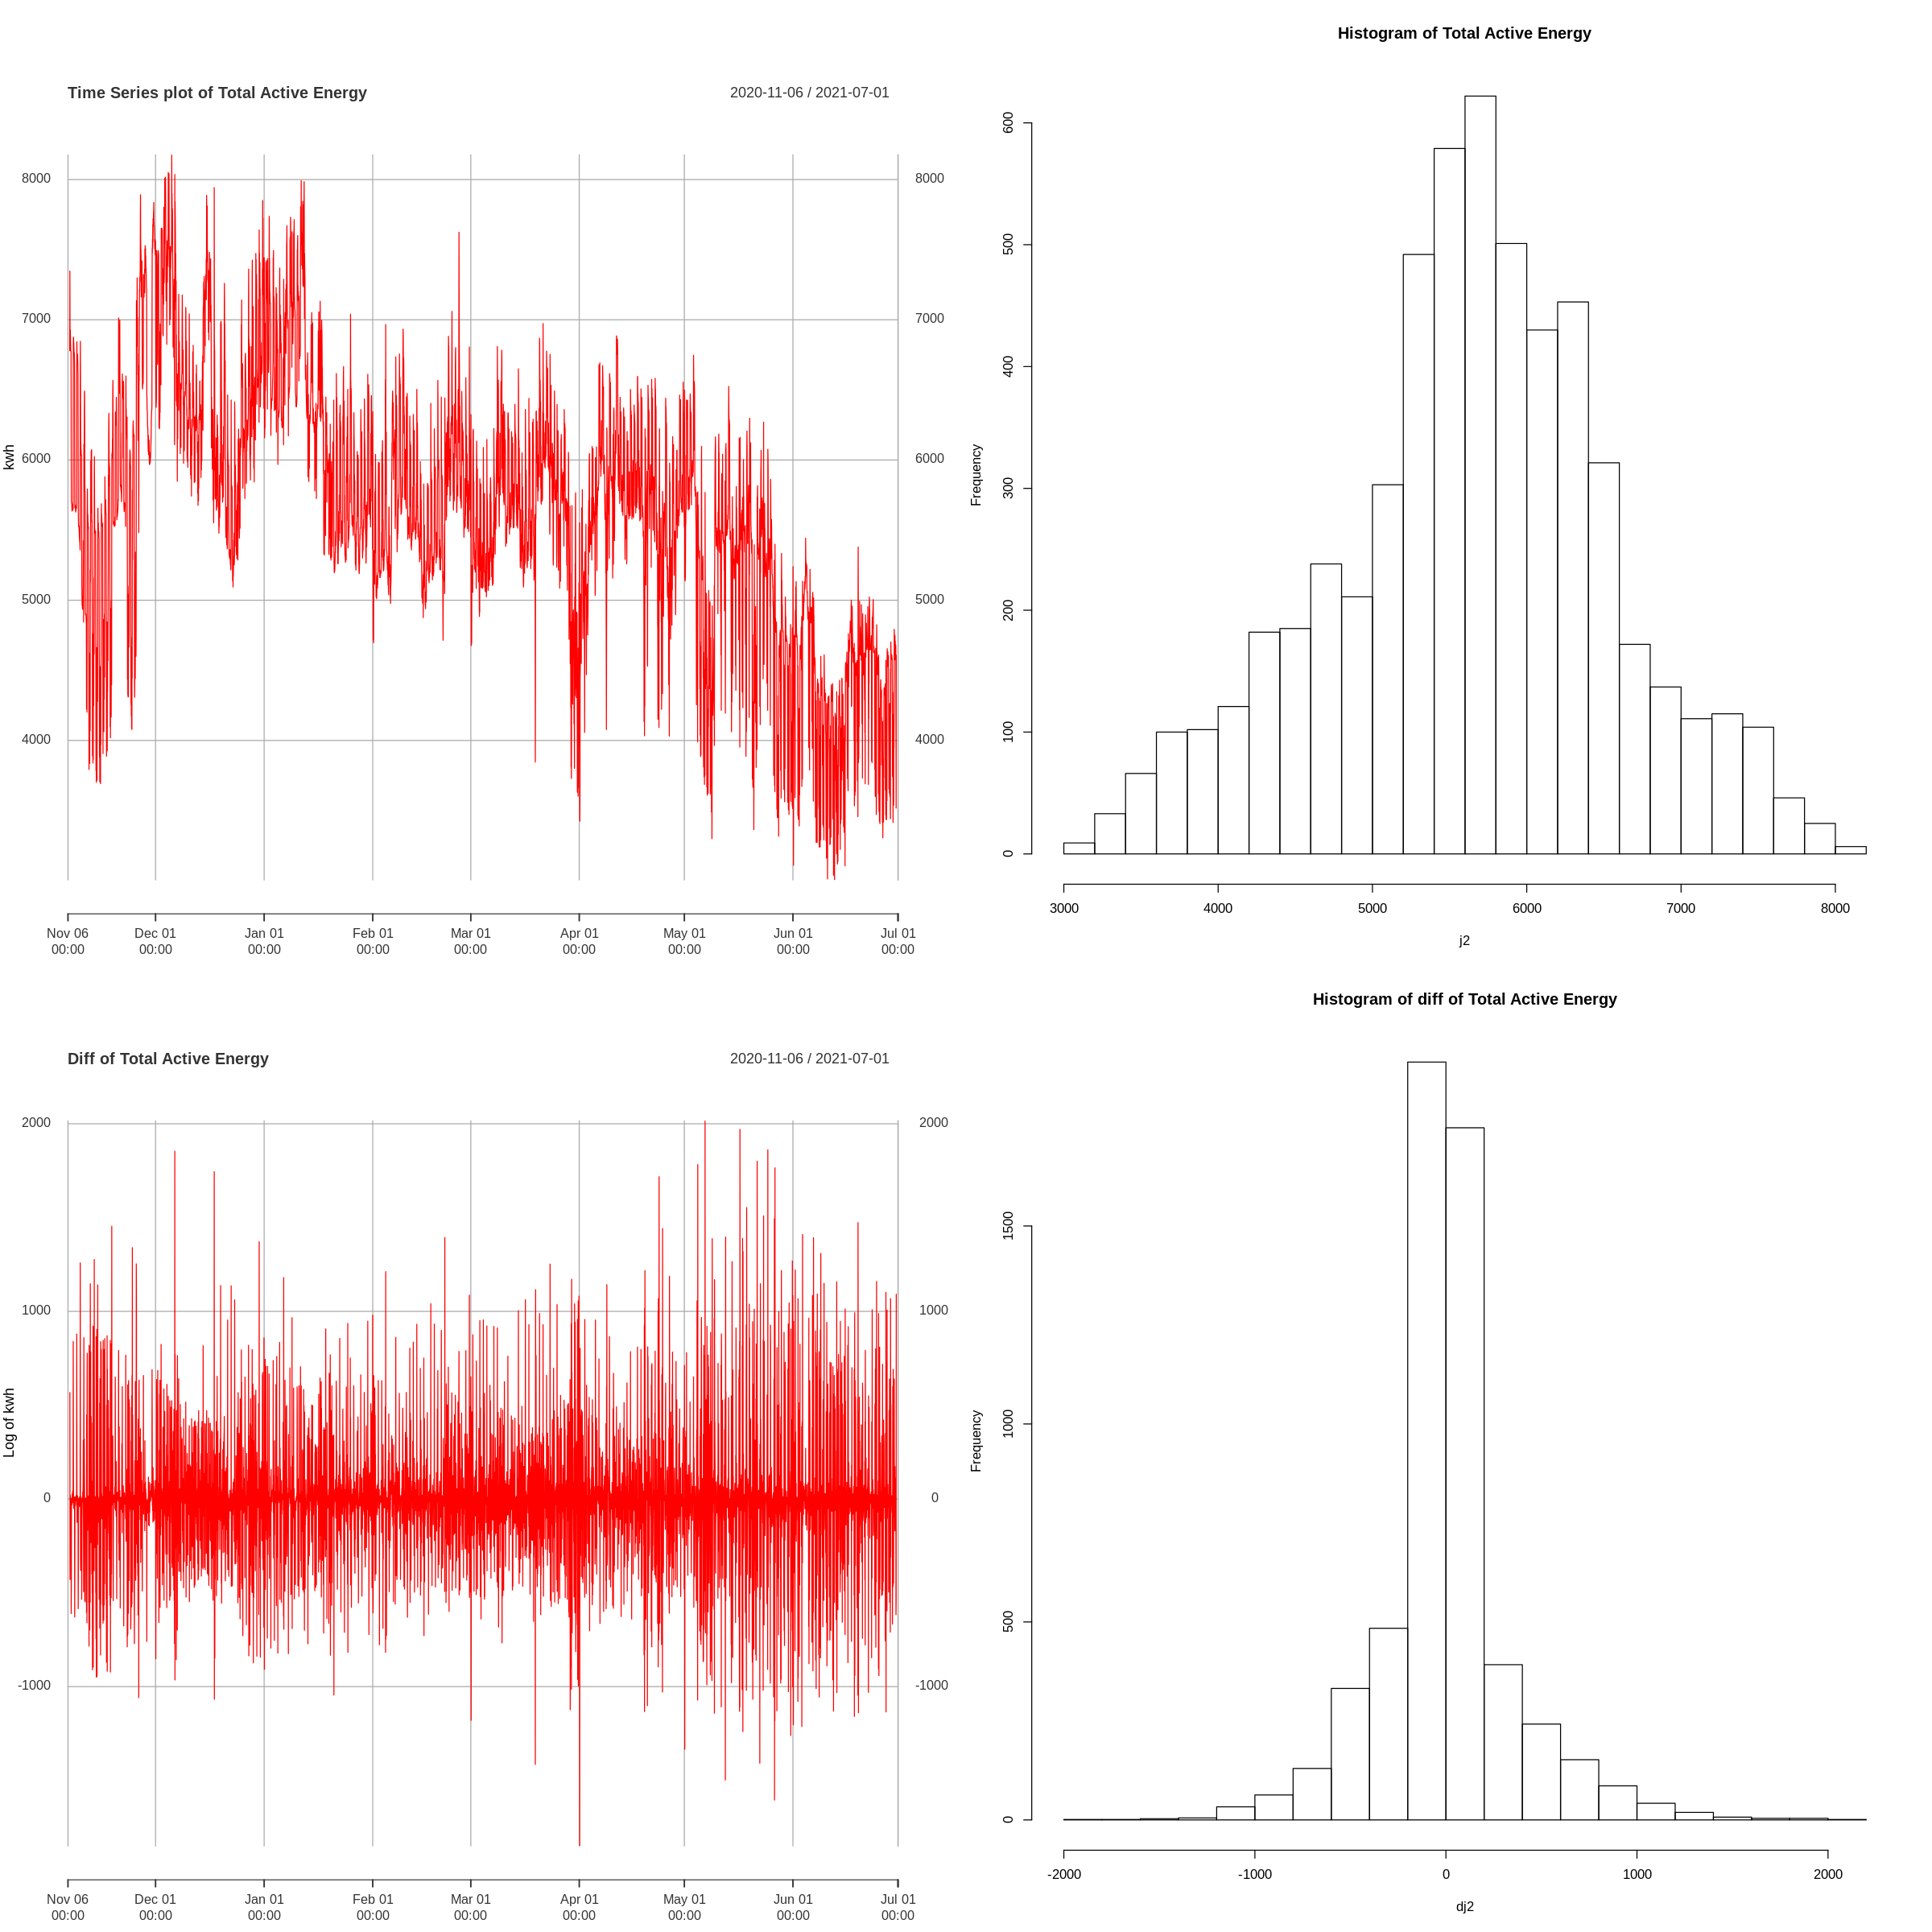

In [489]:
options(repr.plot.width=20, repr.plot.height=20)
par(mfrow=c(2,2)) # set up the graphics
plot(j2,type="l", col='red', lwd=1,main="Time Series plot of Total Active Energy", ylab="kwh")
hist(j2, nclass=25, main="Histogram of Total Active Energy")
plot(dj2,type="l", col='red', lwd=1,main="Diff of Total Active Energy", ylab="Log of kwh")
hist(dj2, nclass=25, main="Histogram of diff of Total Active Energy")

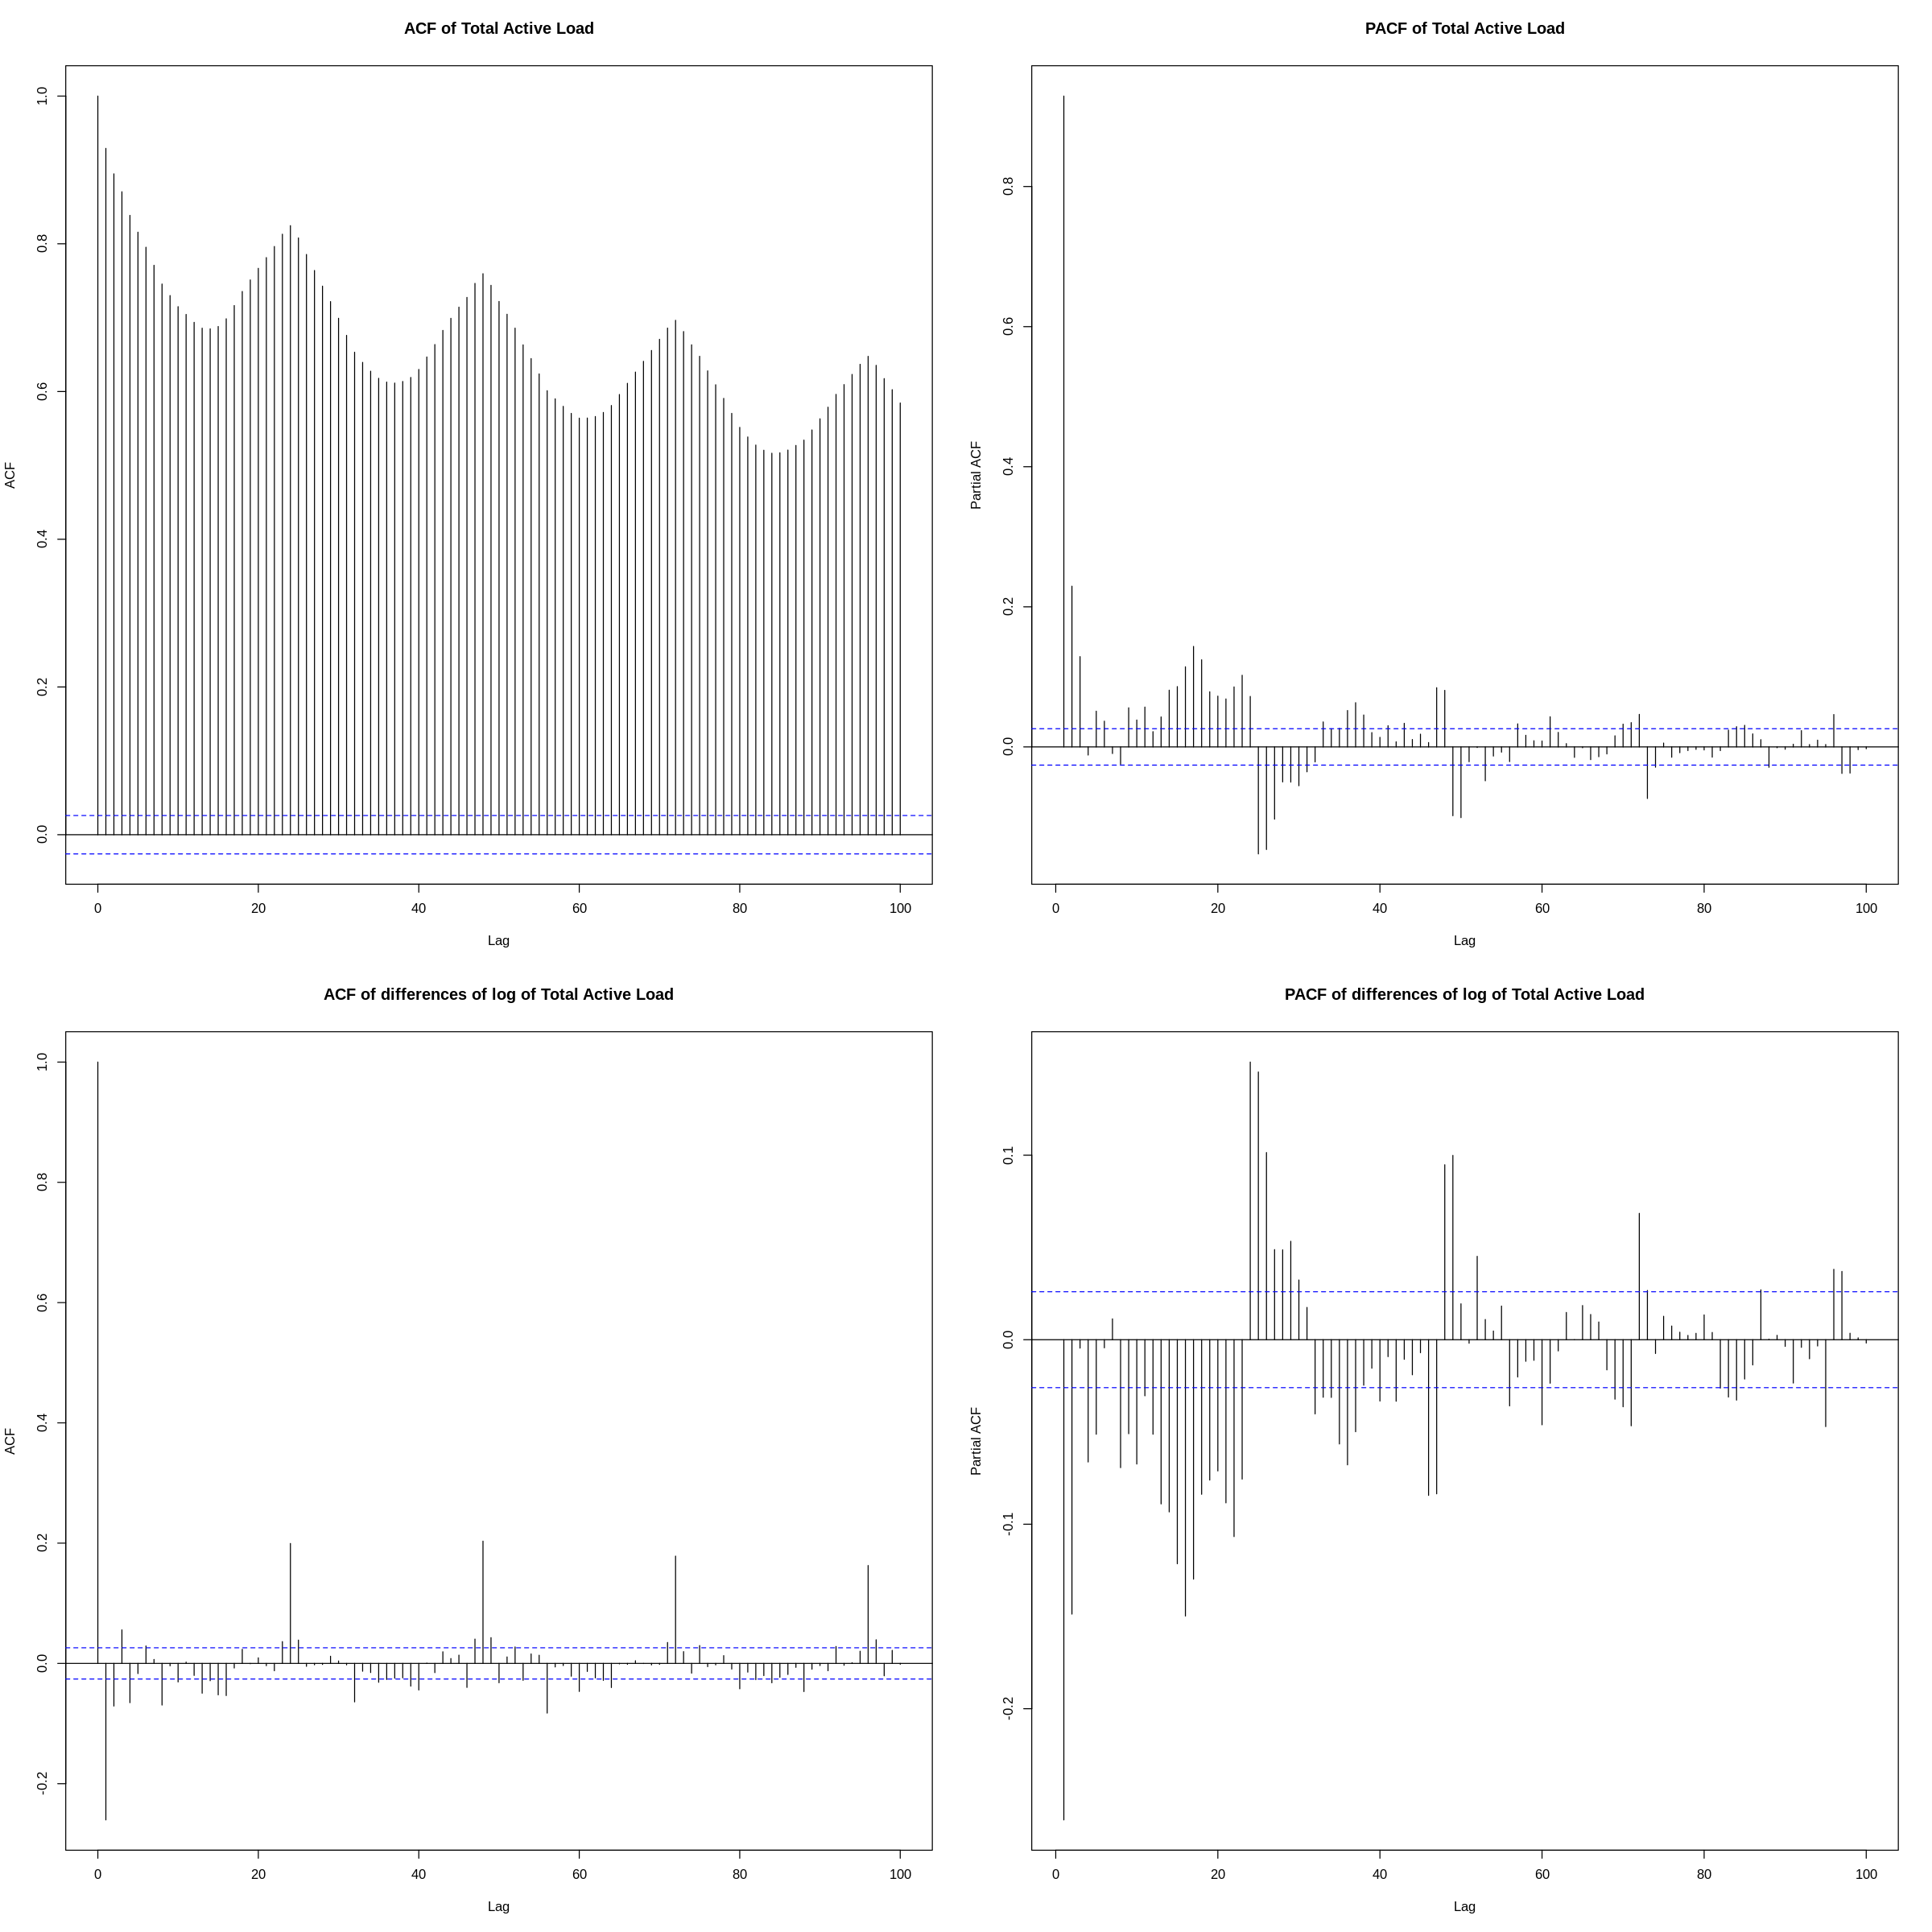

In [490]:
par(mfrow=c(2,2)) # set up the graphics
acf(ts(j2, freq=1), 100, main="ACF of Total Active Load", na.action = na.pass) # autocorrelation function plot
pacf(ts(j2, freq=1), 100, main="PACF of Total Active Load", na.action = na.pass) # partial autocorrelation function
acf(ts(dj2, freq=1), 100, main="ACF of differences of log of Total Active Load", na.action = na.pass)
pacf(ts(dj2, freq=1), 100, main="PACF of differences of log of Total Active Load", na.action = na.pass)

Not many things change with decomposition (strange)

## Unit root testing 

### Drift

#### Original time series

In [491]:
m=ar(tsclean(j))
m
m$order
m1=ur.df(tsclean(j),type="drift",lags=m$order-1)
m1
summary(m1)


Call:
ar(x = tsclean(j))

Coefficients:
      1        2        3        4        5        6        7        8  
 0.4757   0.0979   0.1168  -0.0526   0.0190   0.0488   0.0287  -0.0385  
      9       10       11       12       13       14       15       16  
 0.0310  -0.0054   0.0153  -0.0081  -0.0075  -0.0052  -0.0286  -0.0117  
     17       18       19       20       21       22       23       24  
 0.0231   0.0422   0.0220   0.0272   0.0014   0.0326   0.1029   0.2082  
     25       26       27       28       29       30       31       32  
-0.0147  -0.0476  -0.0389   0.0061   0.0032  -0.0228  -0.0220  -0.0369  

Order selected 32  sigma^2 estimated as  84222

[1] 32


############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -3.793 7.2403 



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1515.45  -128.79     6.31   134.40  1746.80 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  99.275543  26.763752   3.709  0.00021 ***
z.lag.1      -0.035673   0.009405  -3.793  0.00015 ***
z.diff.lag1  -0.495612   0.015945 -31.083  < 2e-16 ***
z.diff.lag2  -0.398788   0.017264 -23.099  < 2e-16 ***
z.diff.lag3  -0.282942   0.018057 -15.670  < 2e-16 ***
z.diff.lag4  -0.335978   0.018440 -18.220  < 2e-16 ***
z.diff.lag5  -0.317088   0.018972 -16.714  < 2e-16 ***
z.diff.lag6  -0.267898   0.019414 -13.799  < 2e-16 ***
z.diff.lag7  -0.238916   0.019677 -12.142  < 2e-16 ***
z.diff.lag8  -0.276943   0.019853 -13.949  < 2e-16 ***
z.diff.lag9  -0.245037   0.020168 -12.150  < 2e-

#### Diff time series

In [492]:
m=ar(tsclean(dj))
m
m$order
m1=ur.df(tsclean(dj),type="drift",lags=m$order-1)
m1
summary(m1)


Call:
ar(x = tsclean(dj))

Coefficients:
      1        2        3        4        5        6        7        8  
 0.0356  -0.0416   0.0046  -0.0271  -0.0125   0.0236   0.0055  -0.0172  
      9       10       11       12       13       14       15       16  
 0.0101  -0.0282  -0.0021  -0.0035  -0.0214  -0.0067  -0.0285  -0.0238  
     17       18       19       20       21       22       23       24  
-0.0016   0.0091   0.0207   0.0012  -0.0052   0.0031   0.0733   0.1297  
     25       26       27       28       29       30       31       32  
 0.0301   0.0174  -0.0233   0.0056  -0.0049  -0.0089  -0.0234  -0.0312  
     33  
-0.0234  

Order selected 33  sigma^2 estimated as  48629

[1] 33


############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -12.4211 77.1426 



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-741.87  -94.15   10.85   94.10  733.88 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -21.440048   3.401322  -6.303 3.13e-10 ***
z.lag.1       -0.961154   0.077381 -12.421  < 2e-16 ***
z.diff.lag1   -0.004686   0.076364  -0.061 0.951067    
z.diff.lag2   -0.045177   0.075406  -0.599 0.549115    
z.diff.lag3   -0.040845   0.074489  -0.548 0.583480    
z.diff.lag4   -0.068218   0.073583  -0.927 0.353918    
z.diff.lag5   -0.080921   0.072675  -1.113 0.265558    
z.diff.lag6   -0.056872   0.071744  -0.793 0.427984    
z.diff.lag7   -0.050962   0.070852  -0.719 0.472007    
z.diff.lag8   -0.069039   0.069913  -0.987 0.323443    
z.diff.lag9   -0.058142   0.068886  -0.844 0.39

The null hypothesis of non-stationarity is rejected for all cases with respect to drift.

### Trend

#### Original time series

In [493]:
m=ar(j)
m
m$order
m1=ur.df(j,type="trend",lags=m$order-1)
m1
summary(m1)


Call:
ar(x = j)

Coefficients:
      1        2        3        4        5        6        7        8  
 0.4757   0.0979   0.1168  -0.0526   0.0190   0.0488   0.0287  -0.0385  
      9       10       11       12       13       14       15       16  
 0.0310  -0.0054   0.0153  -0.0081  -0.0075  -0.0052  -0.0286  -0.0117  
     17       18       19       20       21       22       23       24  
 0.0231   0.0422   0.0220   0.0272   0.0014   0.0326   0.1029   0.2082  
     25       26       27       28       29       30       31       32  
-0.0147  -0.0476  -0.0389   0.0061   0.0032  -0.0228  -0.0220  -0.0369  

Order selected 32  sigma^2 estimated as  84222

[1] 32


############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -5.4395 9.9112 14.8198 



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1507.68  -129.81     6.75   135.06  1737.56 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  232.987746  43.468053   5.360 8.66e-08 ***
z.lag.1       -0.070303   0.012924  -5.440 5.57e-08 ***
tt            -0.012684   0.003252  -3.901 9.70e-05 ***
z.diff.lag1   -0.463595   0.017916 -25.877  < 2e-16 ***
z.diff.lag2   -0.368067   0.018956 -19.417  < 2e-16 ***
z.diff.lag3   -0.253190   0.019581 -12.931  < 2e-16 ***
z.diff.lag4   -0.306891   0.019869 -15.446  < 2e-16 ***
z.diff.lag5   -0.288816   0.020287 -14.237  < 2e-16 ***
z.diff.lag6   -0.240301   0.020640 -11.643  < 2e-16 ***
z.diff.lag7   -0.211763   0.020848 -10.157  < 2e-16 ***
z.diff.lag8   -0.250127   0.0209

#### Diff time series

In [494]:
m=ar(tsclean(dj))
m
m$order
m1=ur.df(tsclean(dj),type="trend",lags=m$order-1)
m1
summary(m1)


Call:
ar(x = tsclean(dj))

Coefficients:
      1        2        3        4        5        6        7        8  
 0.0356  -0.0416   0.0046  -0.0271  -0.0125   0.0236   0.0055  -0.0172  
      9       10       11       12       13       14       15       16  
 0.0101  -0.0282  -0.0021  -0.0035  -0.0214  -0.0067  -0.0285  -0.0238  
     17       18       19       20       21       22       23       24  
-0.0016   0.0091   0.0207   0.0012  -0.0052   0.0031   0.0733   0.1297  
     25       26       27       28       29       30       31       32  
 0.0301   0.0174  -0.0233   0.0056  -0.0049  -0.0089  -0.0234  -0.0312  
     33  
-0.0234  

Order selected 33  sigma^2 estimated as  48629

[1] 33


############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -12.4364 51.5553 77.3323 



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-739.38  -94.00   10.60   94.42  730.97 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -18.246690   6.101297  -2.991 0.002796 ** 
z.lag.1       -0.963574   0.077480 -12.436  < 2e-16 ***
tt            -0.001138   0.001805  -0.630 0.528420    
z.diff.lag1   -0.002337   0.076459  -0.031 0.975616    
z.diff.lag2   -0.042900   0.075496  -0.568 0.569900    
z.diff.lag3   -0.038641   0.074575  -0.518 0.604378    
z.diff.lag4   -0.066090   0.073664  -0.897 0.369661    
z.diff.lag5   -0.078868   0.072752  -1.084 0.278382    
z.diff.lag6   -0.054893   0.071816  -0.764 0.444692    
z.diff.lag7   -0.049059   0.070920  -0.692 0.489122    
z.diff.lag8   -0.067216   0.069977  -0.961

The null hypothesis of non-stationarity is rejected for all cases with respect to trend.

## Normality tests


	Shapiro-Wilk normality test

data:  sample(coredata(j), 5000, replace = FALSE)
W = 0.98638, p-value < 2.2e-16


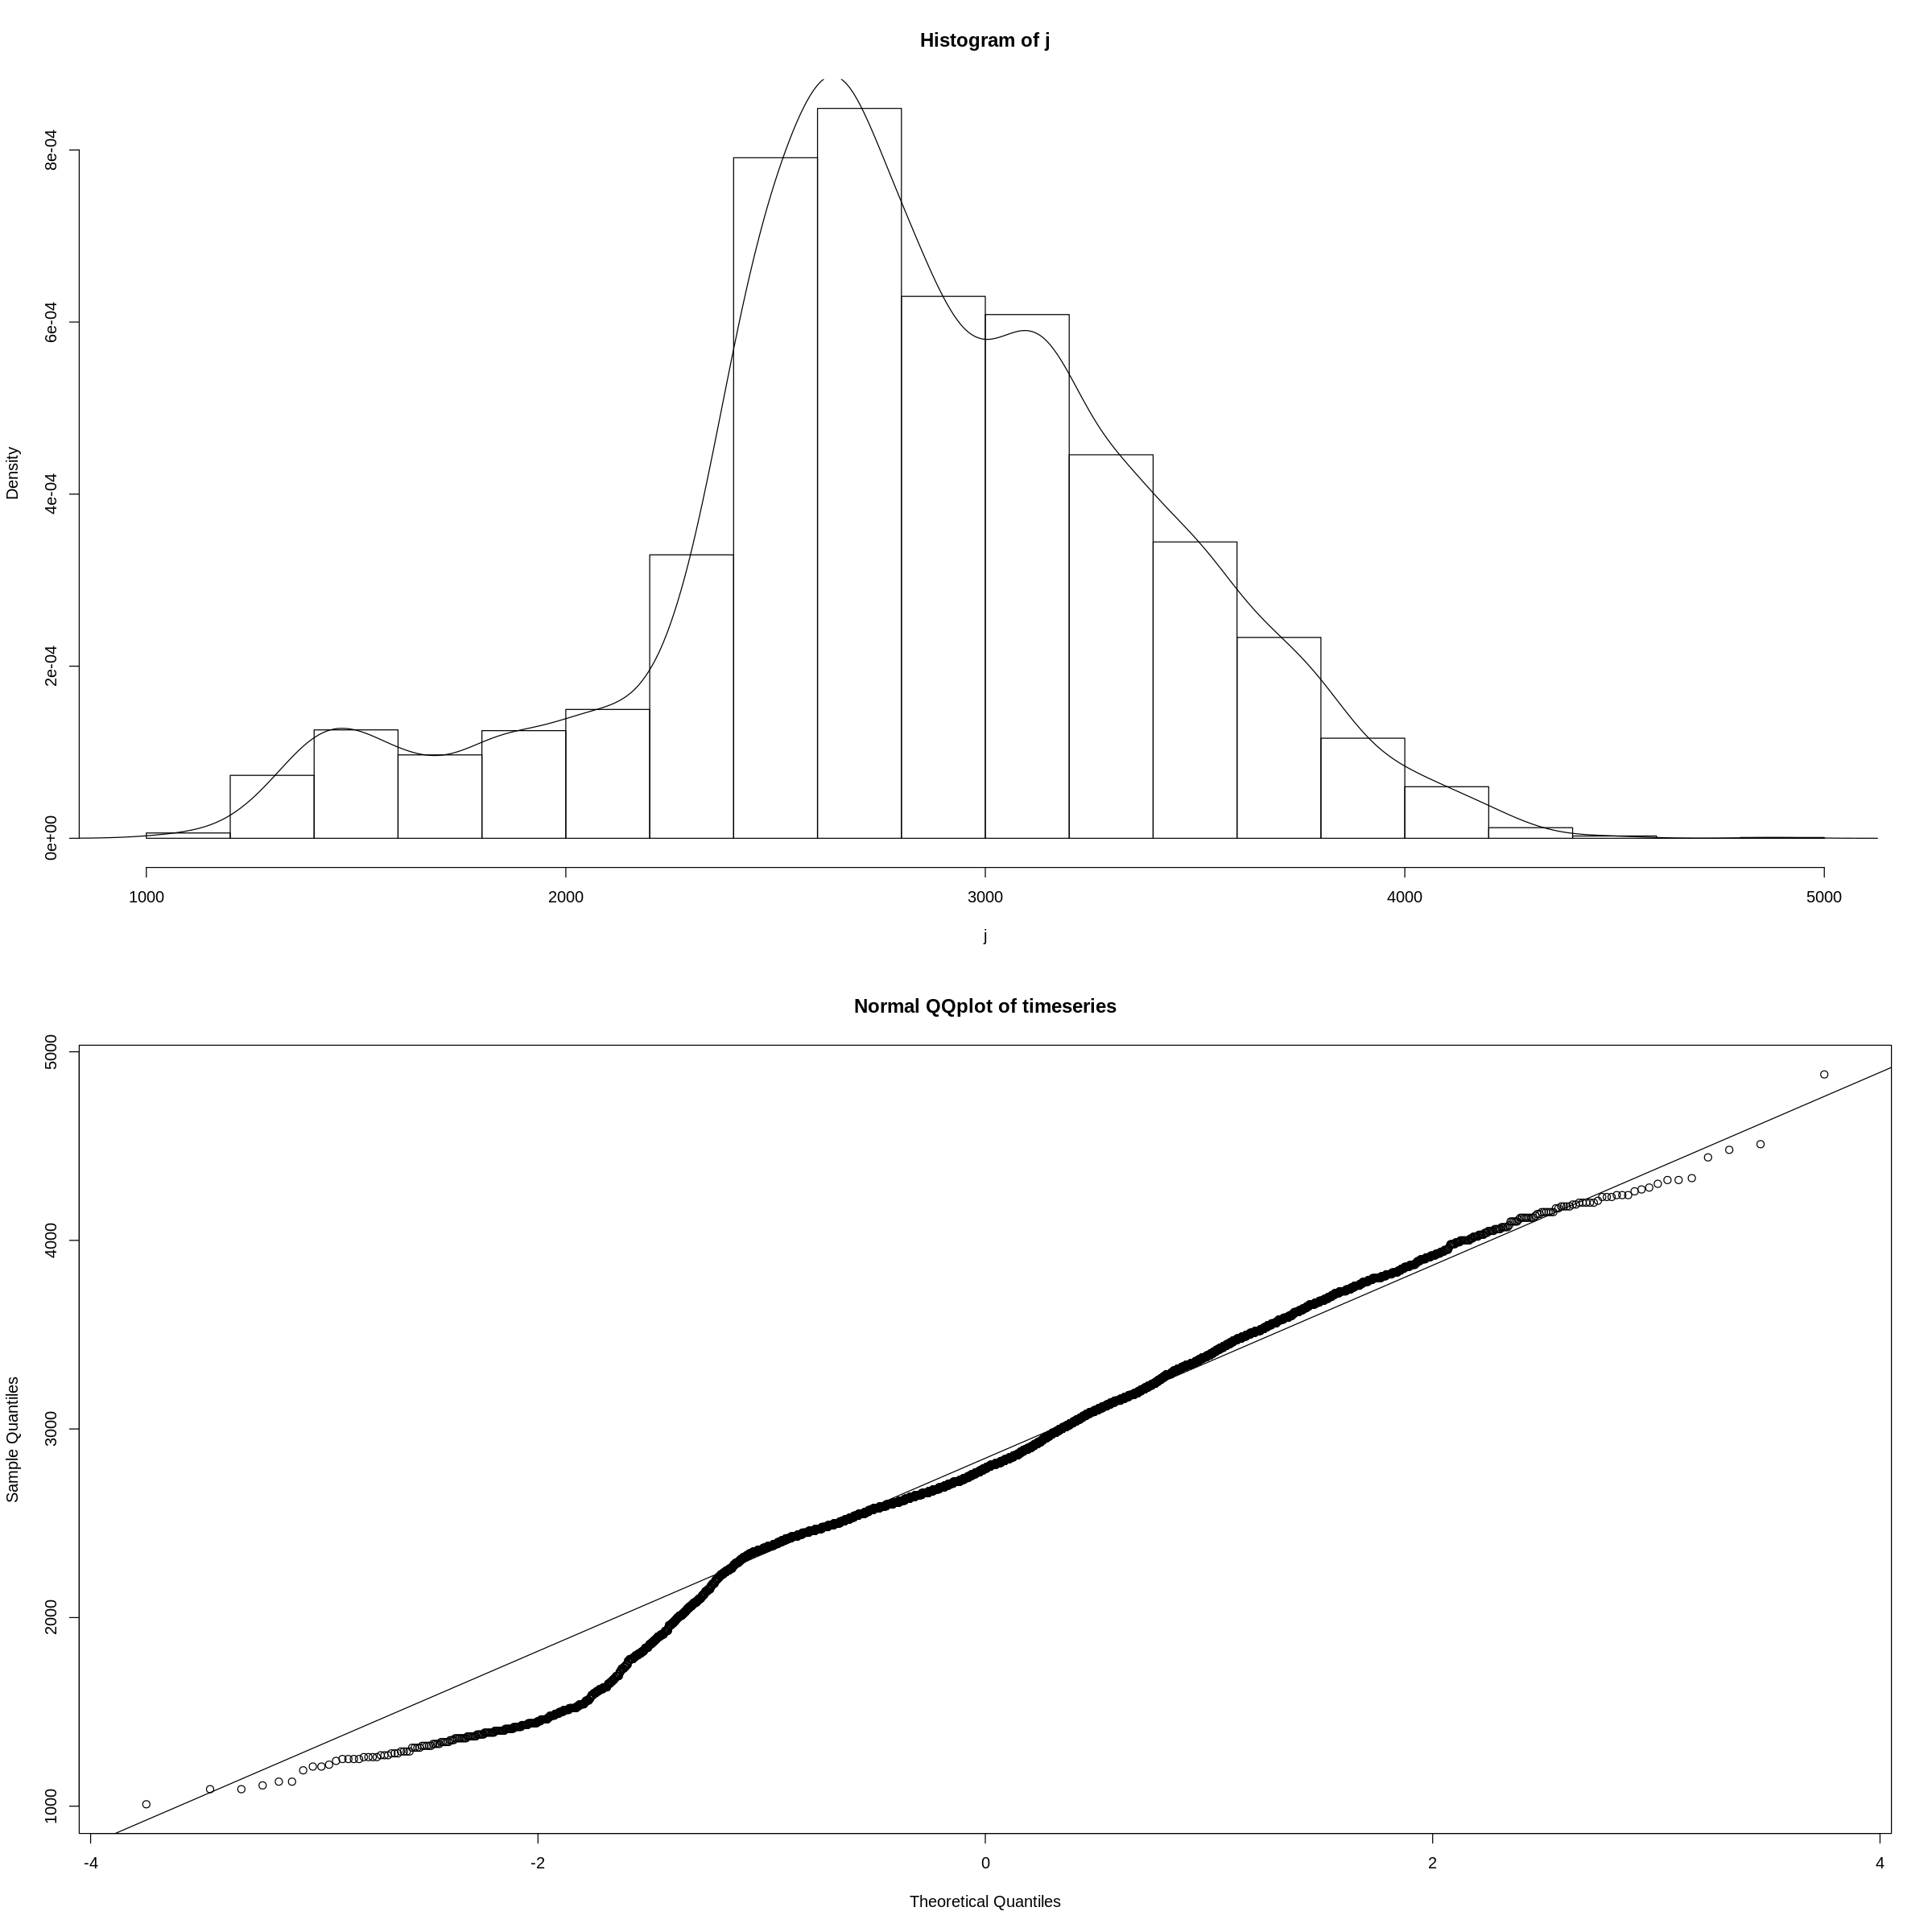

In [495]:
shapiro.test(sample(coredata(j), 5000, replace=FALSE))

par(mfrow=c(2,1))
hist(j, prob=TRUE, 15) # histogram
lines(density(j)) # smooth it - ?density for details
qqnorm(j,main="Normal QQplot of timeseries") # normal Q-Q plot
qqline(j)


	Shapiro-Wilk normality test

data:  sample(coredata(dj), 5000, replace = FALSE)
W = 0.9105, p-value < 2.2e-16


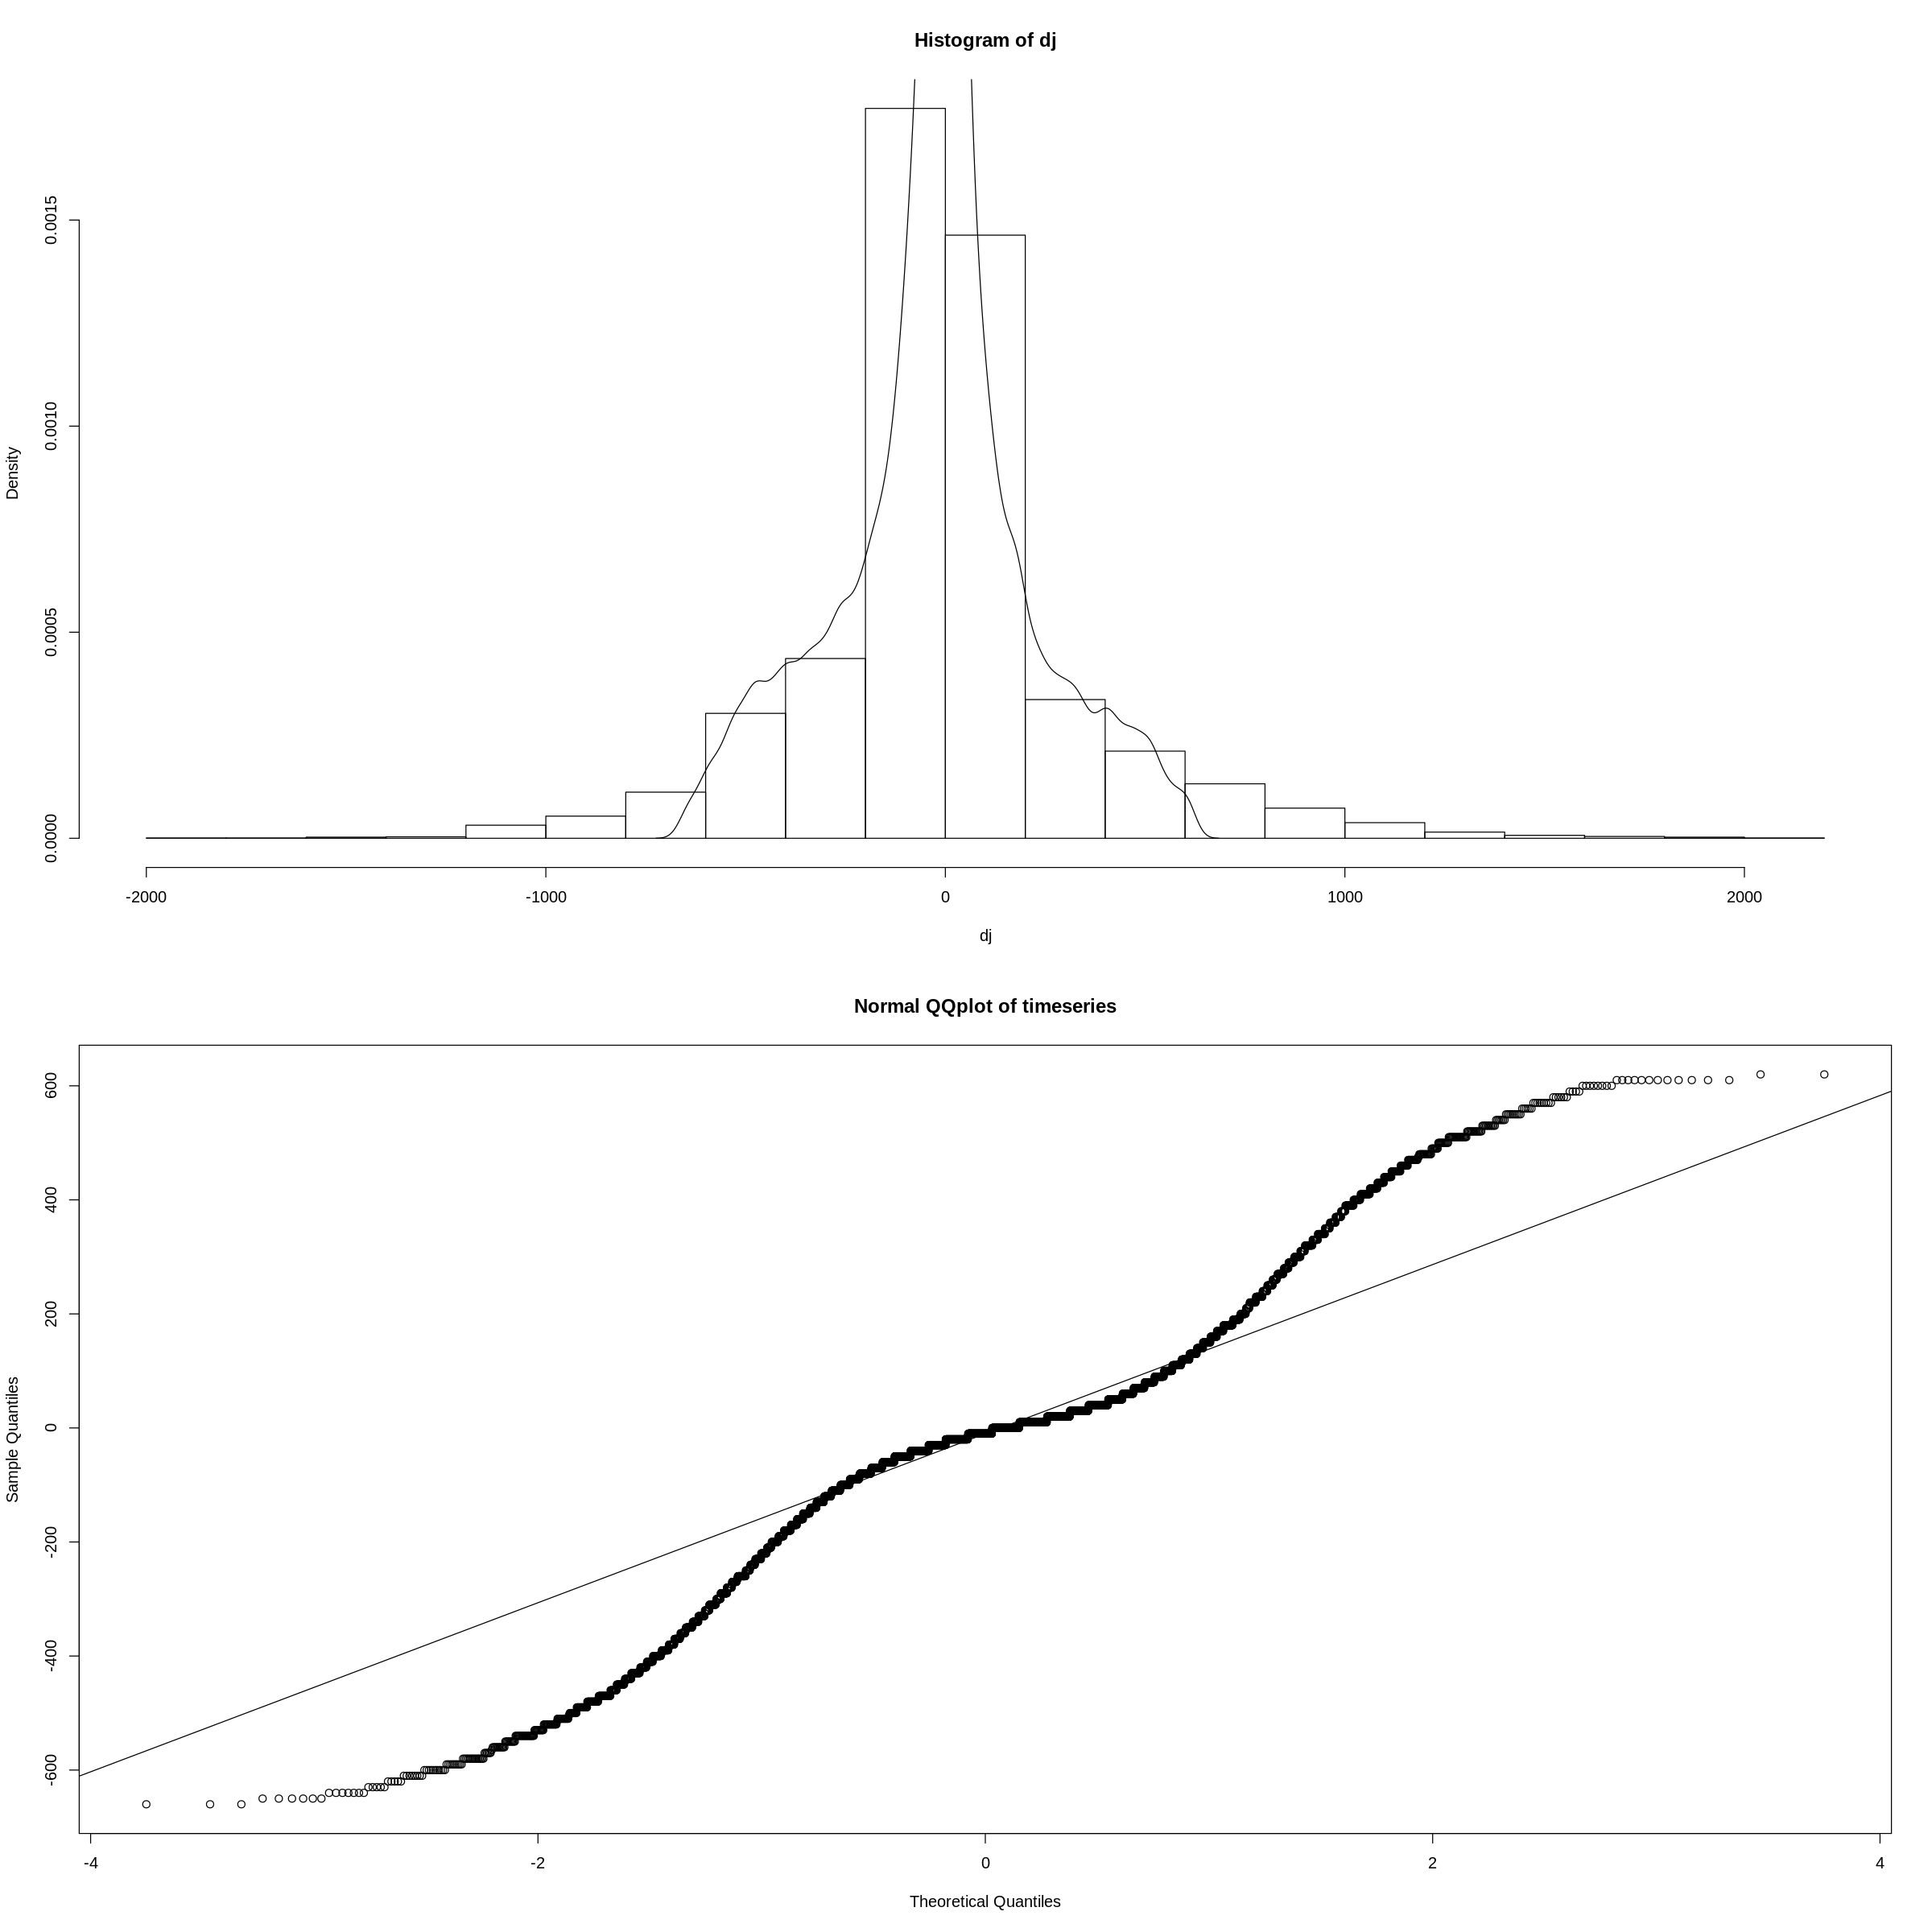

In [496]:
shapiro.test(sample(coredata(dj), 5000, replace=FALSE))

par(mfrow=c(2,1))
hist(dj, prob=TRUE, 15) # histogram
lines(density(tsclean(dj))) # smooth it - ?density for details
qqnorm(tsclean(dj),main="Normal QQplot of timeseries") # normal Q-Q plot
qqline(dj)

Null hypothesis for normality is rejected in all cases according to the Shapiro tests and qqplots. So we will need to consider the BoxCox transformation in the training process.

### Box Cox transform
A sample Box Cox transformation


	Shapiro-Wilk normality test

data:  sample(coredata(normalised), 5000, replace = FALSE)
W = 0.99557, p-value = 3.505e-11


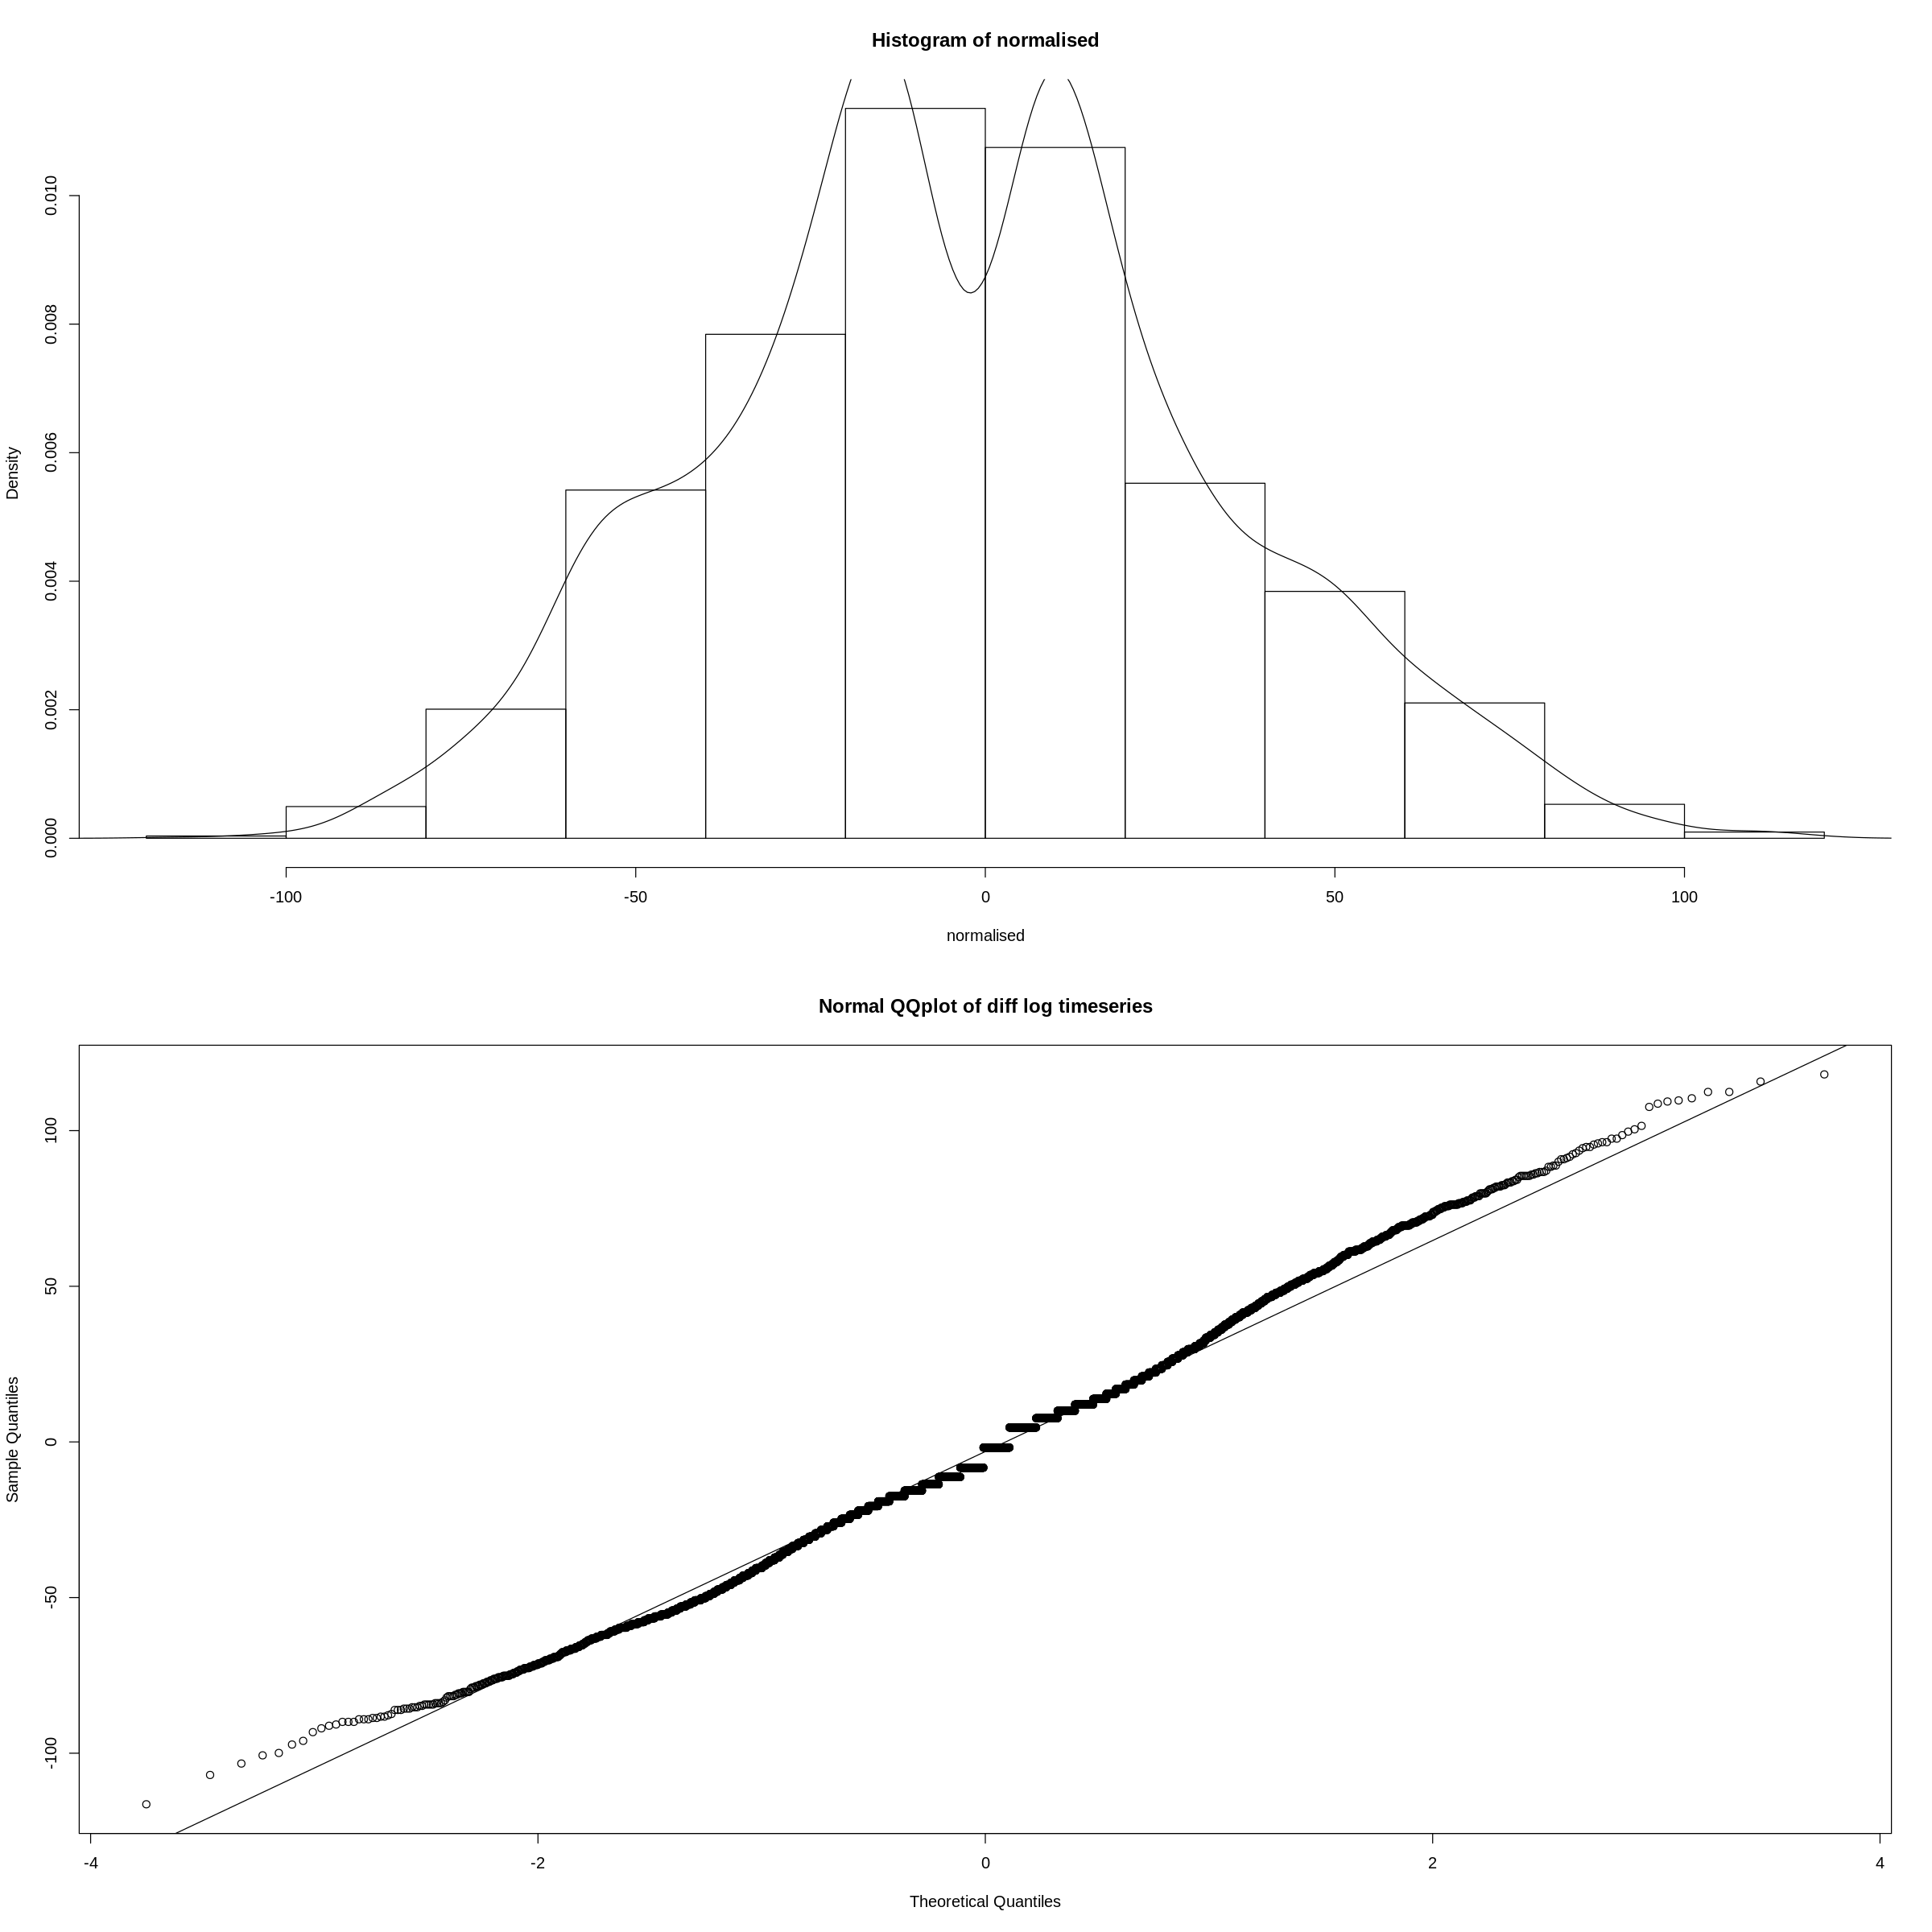

In [497]:
normalised=BoxCox(dj, 0.55)
shapiro.test(sample(coredata(normalised), 5000, replace=FALSE))
par(mfrow=c(2,1))
hist(normalised, prob=TRUE, 15) # histogram
lines(density(tsclean(normalised))) # smooth it - ?density for details
qqnorm(tsclean(normalised), main="Normal QQplot of diff log timeseries") # normal Q-Q plot
qqline(normalised)

The box cox transform is somehow effective

In [498]:
ltrain = j['/2021-06-25 23:30:00']
ltest = j['2021-06-25 00:00:00/']

### tbats

Seasonal periods: 24 (daily), 168 (weekly). (1 day = 48 * 30 min timesteps)

In [499]:
tb <- tbats(tsclean(ltrain), use.box.cox = TRUE, use.trend = TRUE,
            seasonal.periods=c(24, 168), use.arma.errors=TRUE, 
            use.parallel=TRUE, num.cores=6, biasadj=TRUE)
tb

TBATS(1, {0,0}, 0.8, {<24,11>, <168,2>})

Call: tbats(y = tsclean(ltrain), use.box.cox = TRUE, use.trend = TRUE, 
    seasonal.periods = c(24, 168), use.arma.errors = TRUE, use.parallel = TRUE, 
    num.cores = 6, biasadj = TRUE)

Parameters
  Lambda: 0.999997
  Alpha: 0.6605808
  Beta: -0.1472744
  Damping Parameter: 0.800005
  Gamma-1 Values: 4.136955e-06 0.0004750427
  Gamma-2 Values: 1.756982e-05 0.0002729328

Seed States:
             [,1]
 [1,] 4325.039392
 [2,] -244.351472
 [3,]   15.608989
 [4,]  -92.982629
 [5,]   -2.104746
 [6,]  -60.558528
 [7,]  -24.274673
 [8,]   -4.452906
 [9,]  -17.891468
[10,]   17.182907
[11,]    8.695867
[12,]    2.723794
[13,]   17.272312
[14,]  228.501305
[15,]    2.575411
[16,]   45.895853
[17,]   30.791727
[18,]  -33.996841
[19,]  -10.806727
[20,]  -27.519679
[21,]  -10.055464
[22,]    3.653246
[23,]  -16.899753
[24,]    3.196062
[25,]  -45.261873
[26,]  -14.203953
[27,]    1.396972
[28,]   -4.242891
attr(,"lambda")
[1] 0.9999968

Sigma: 295.7421


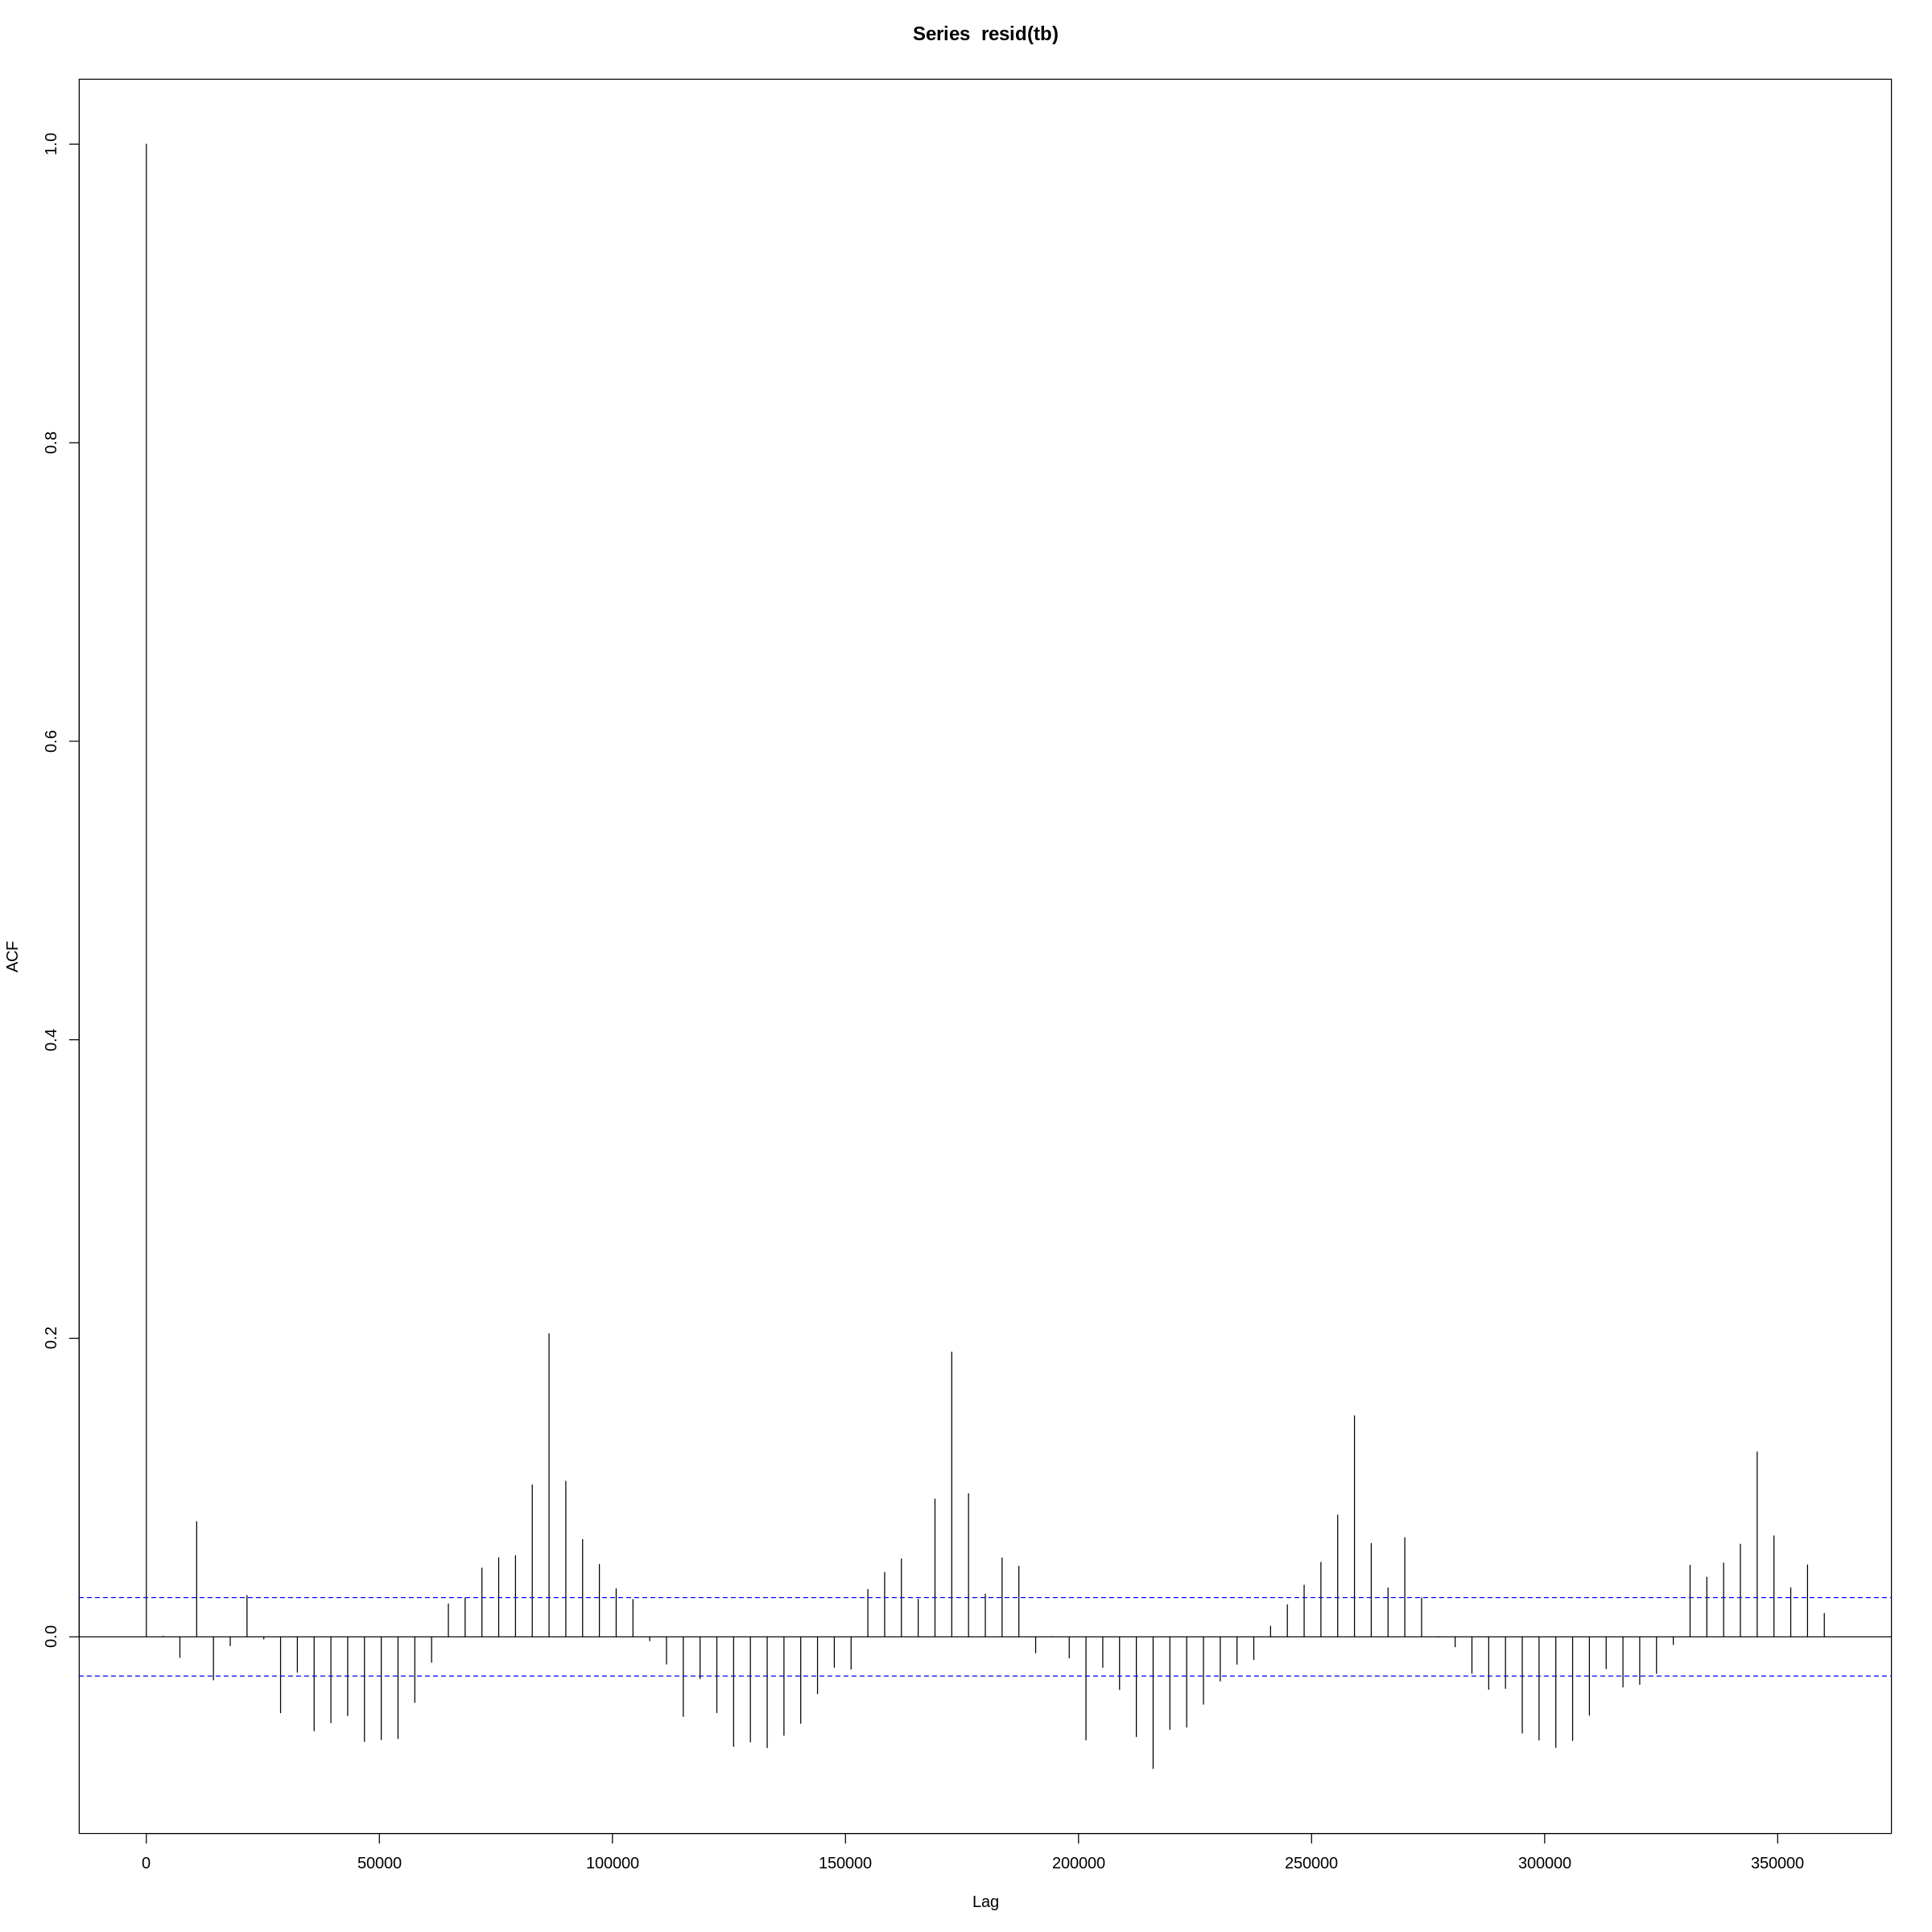

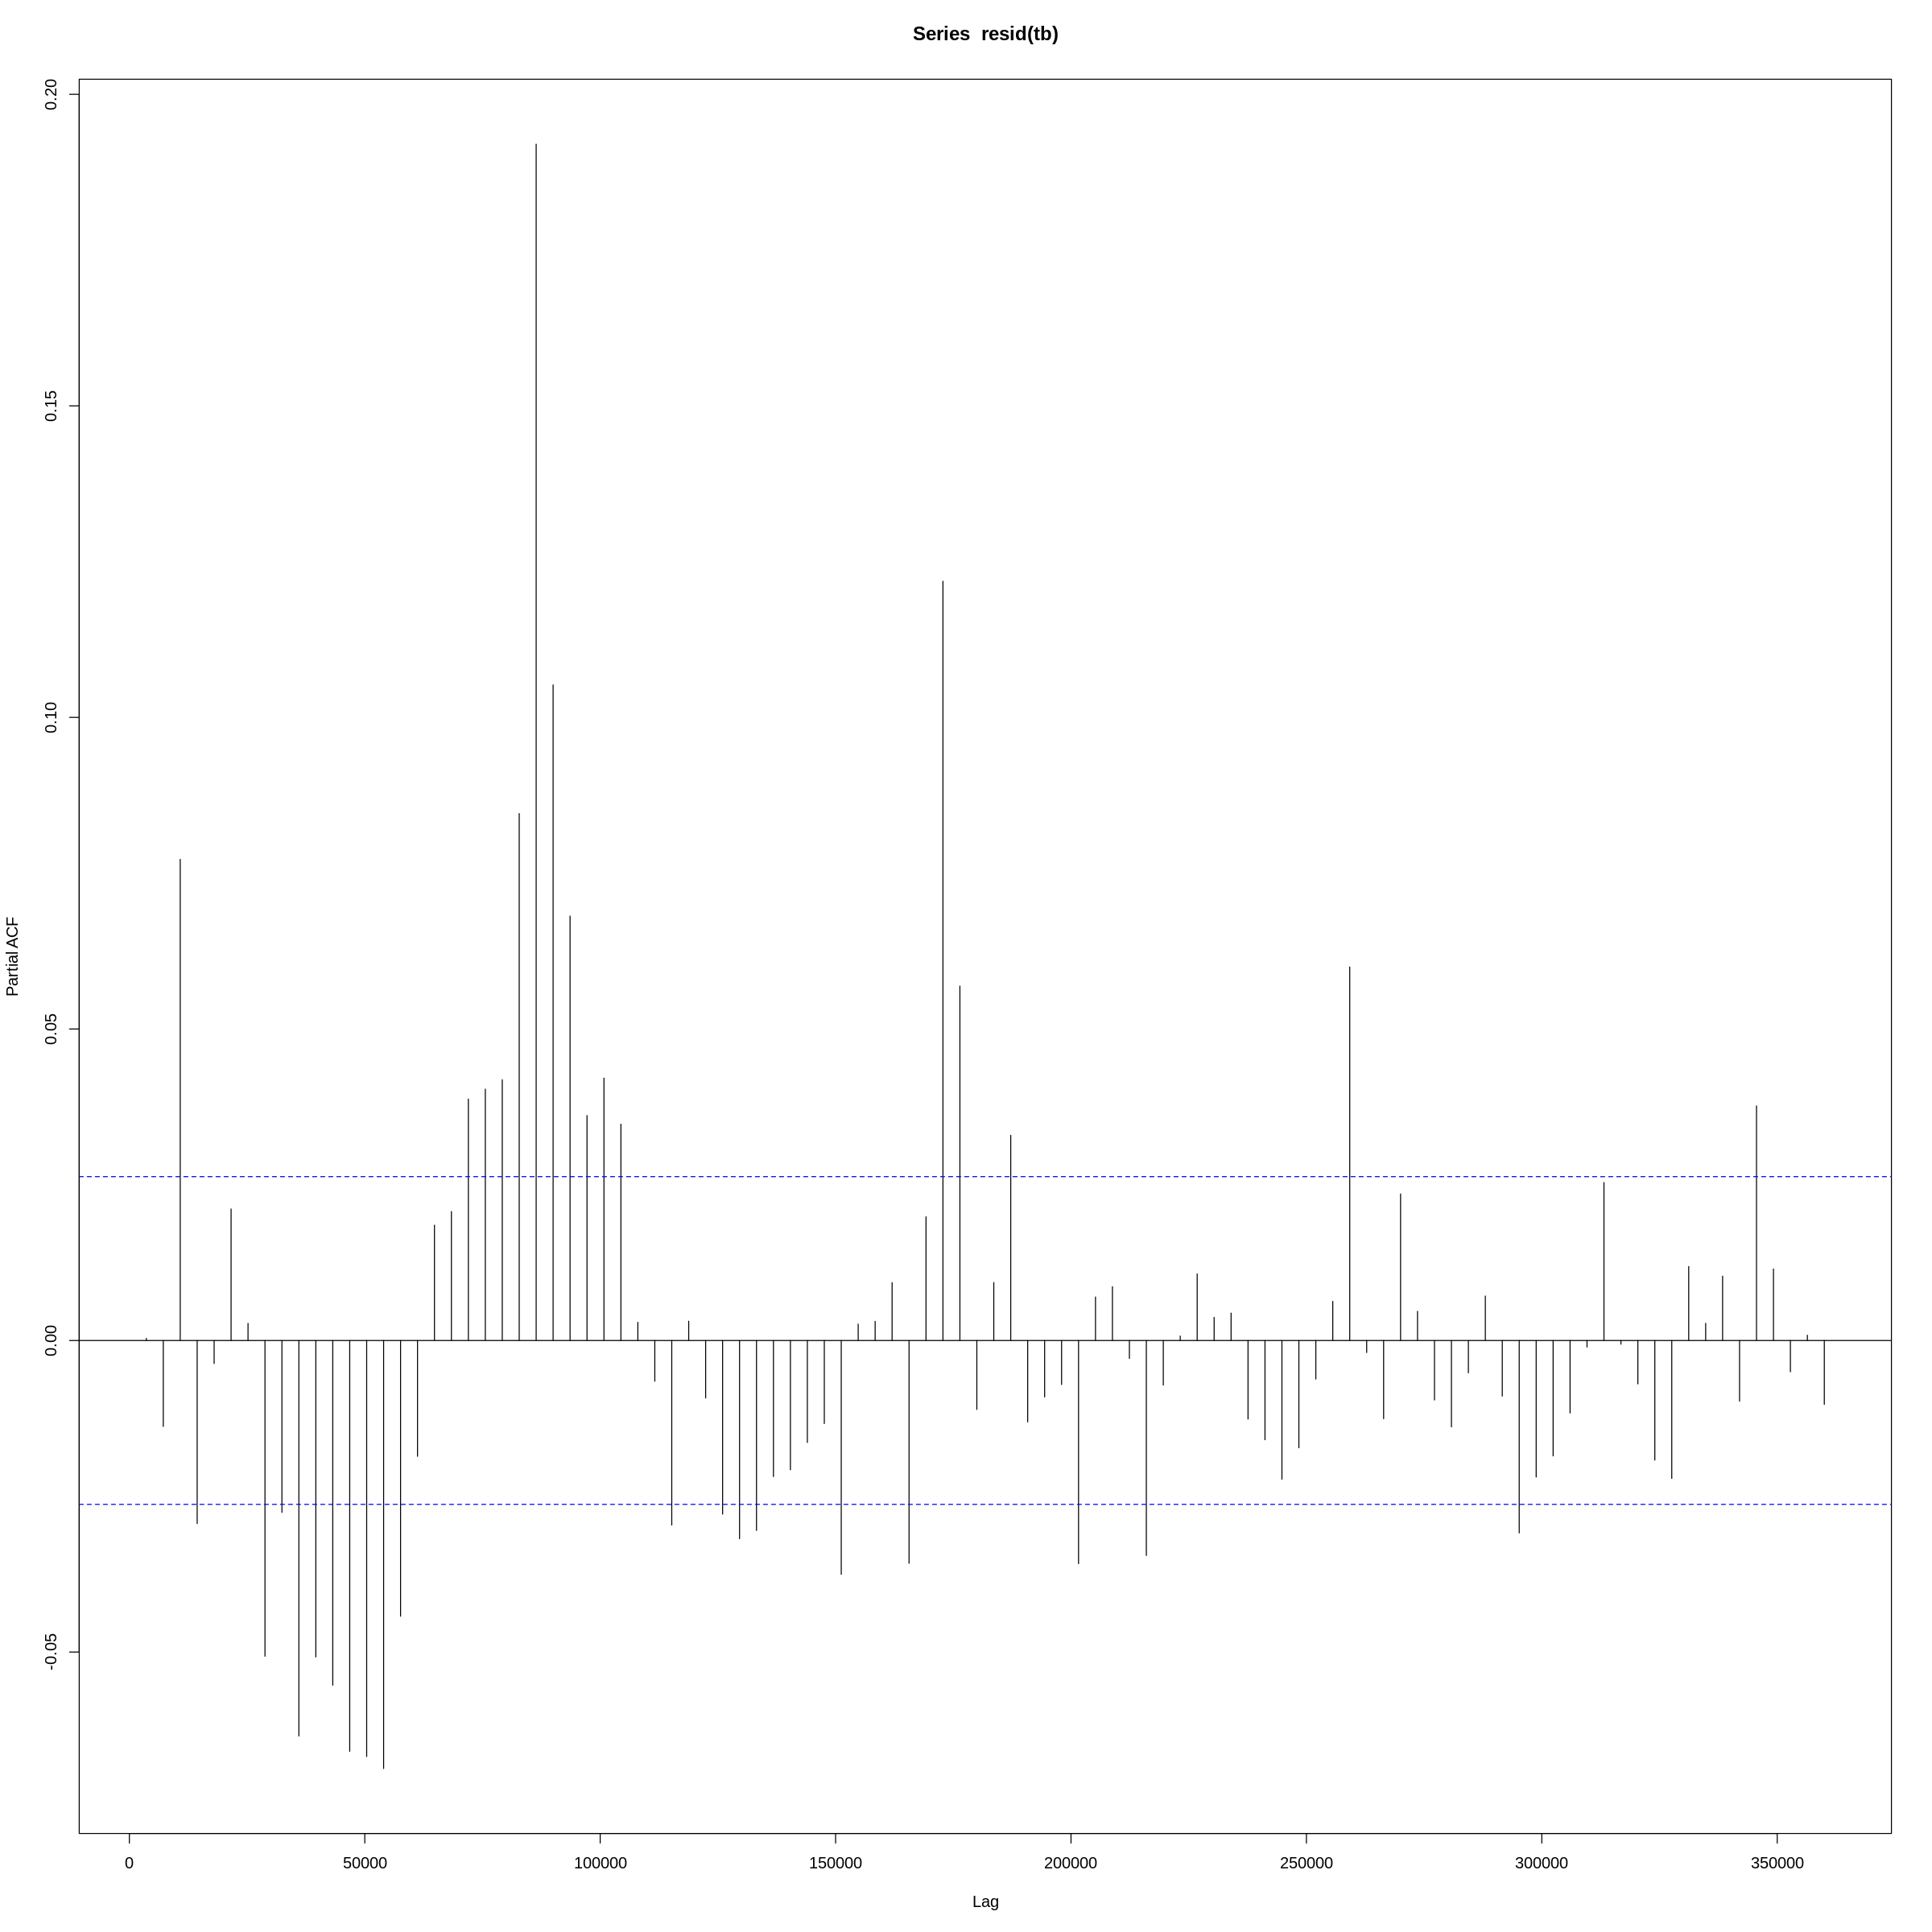

In [500]:
acf(resid(tb),lag.max = 100)
pacf(resid(tb),lag.max=100)

Tbats retains some systematic patterns in residuals. I does not produce the best of results as also demostrated in the python notebook.

### ARIMA and SARIMA
ACF and PACF is plotted again in order to have a look at the possible ar, ma and respective seasonal (sma, sar) terms.

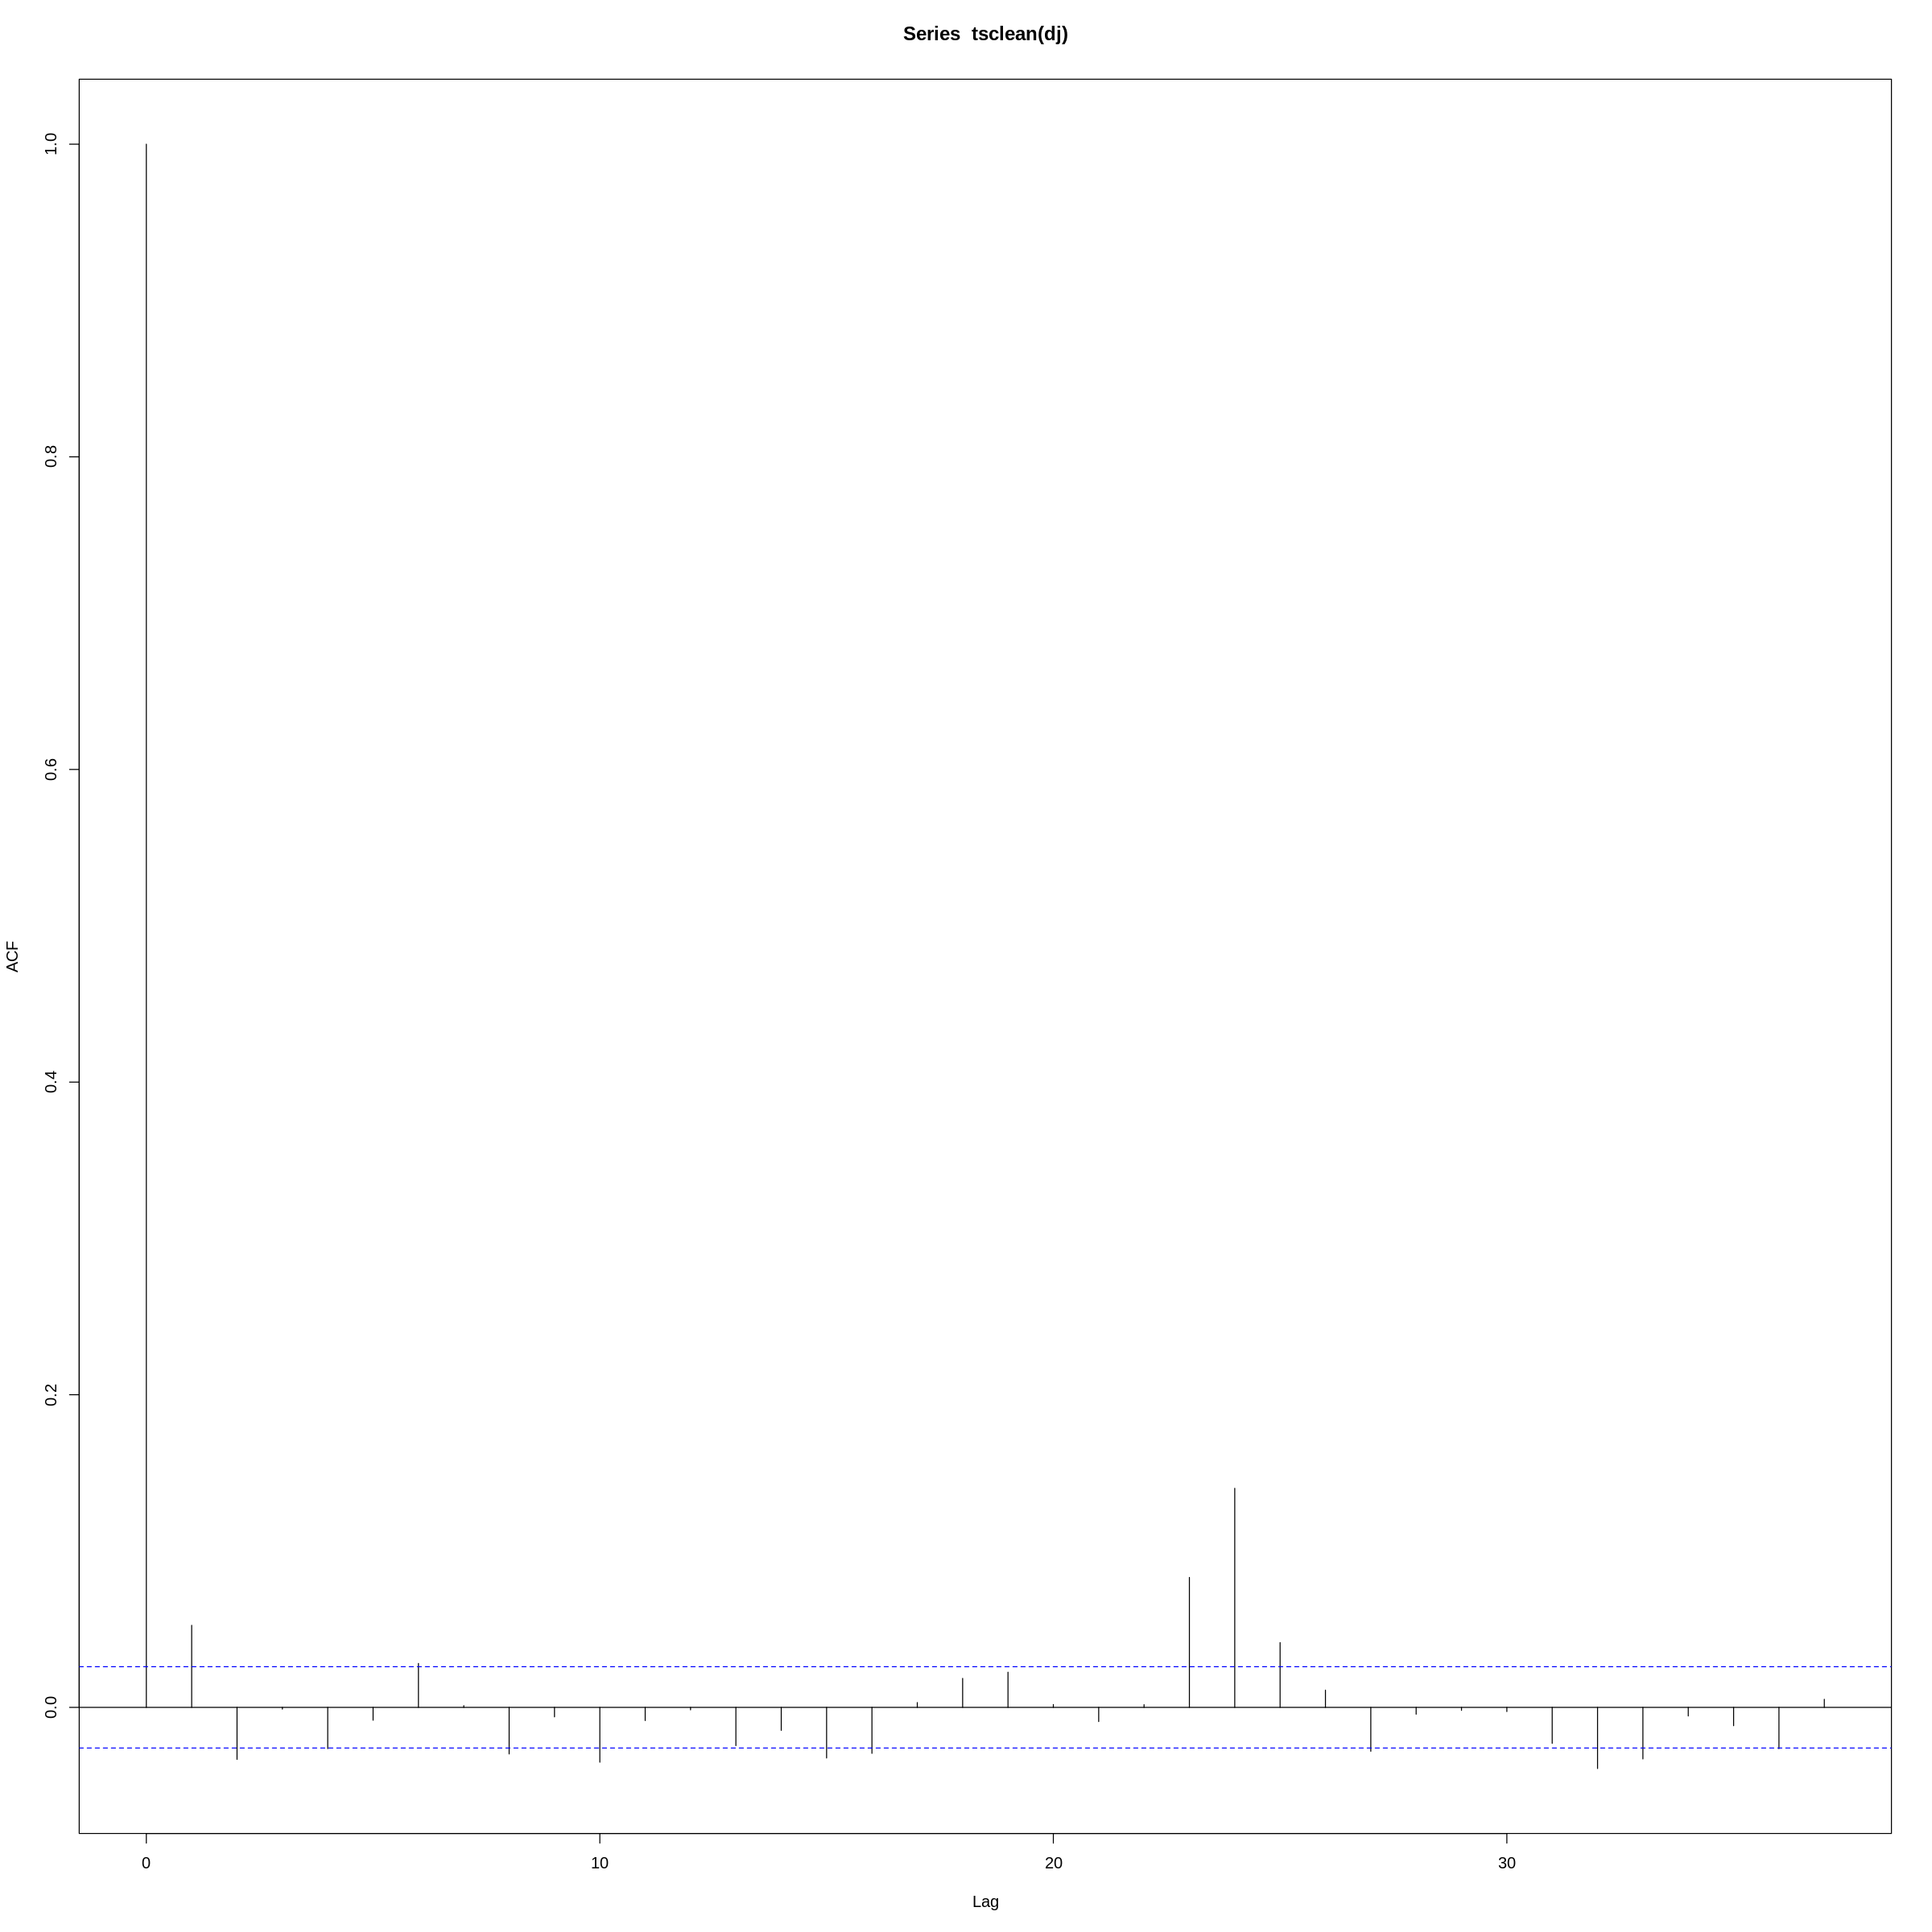

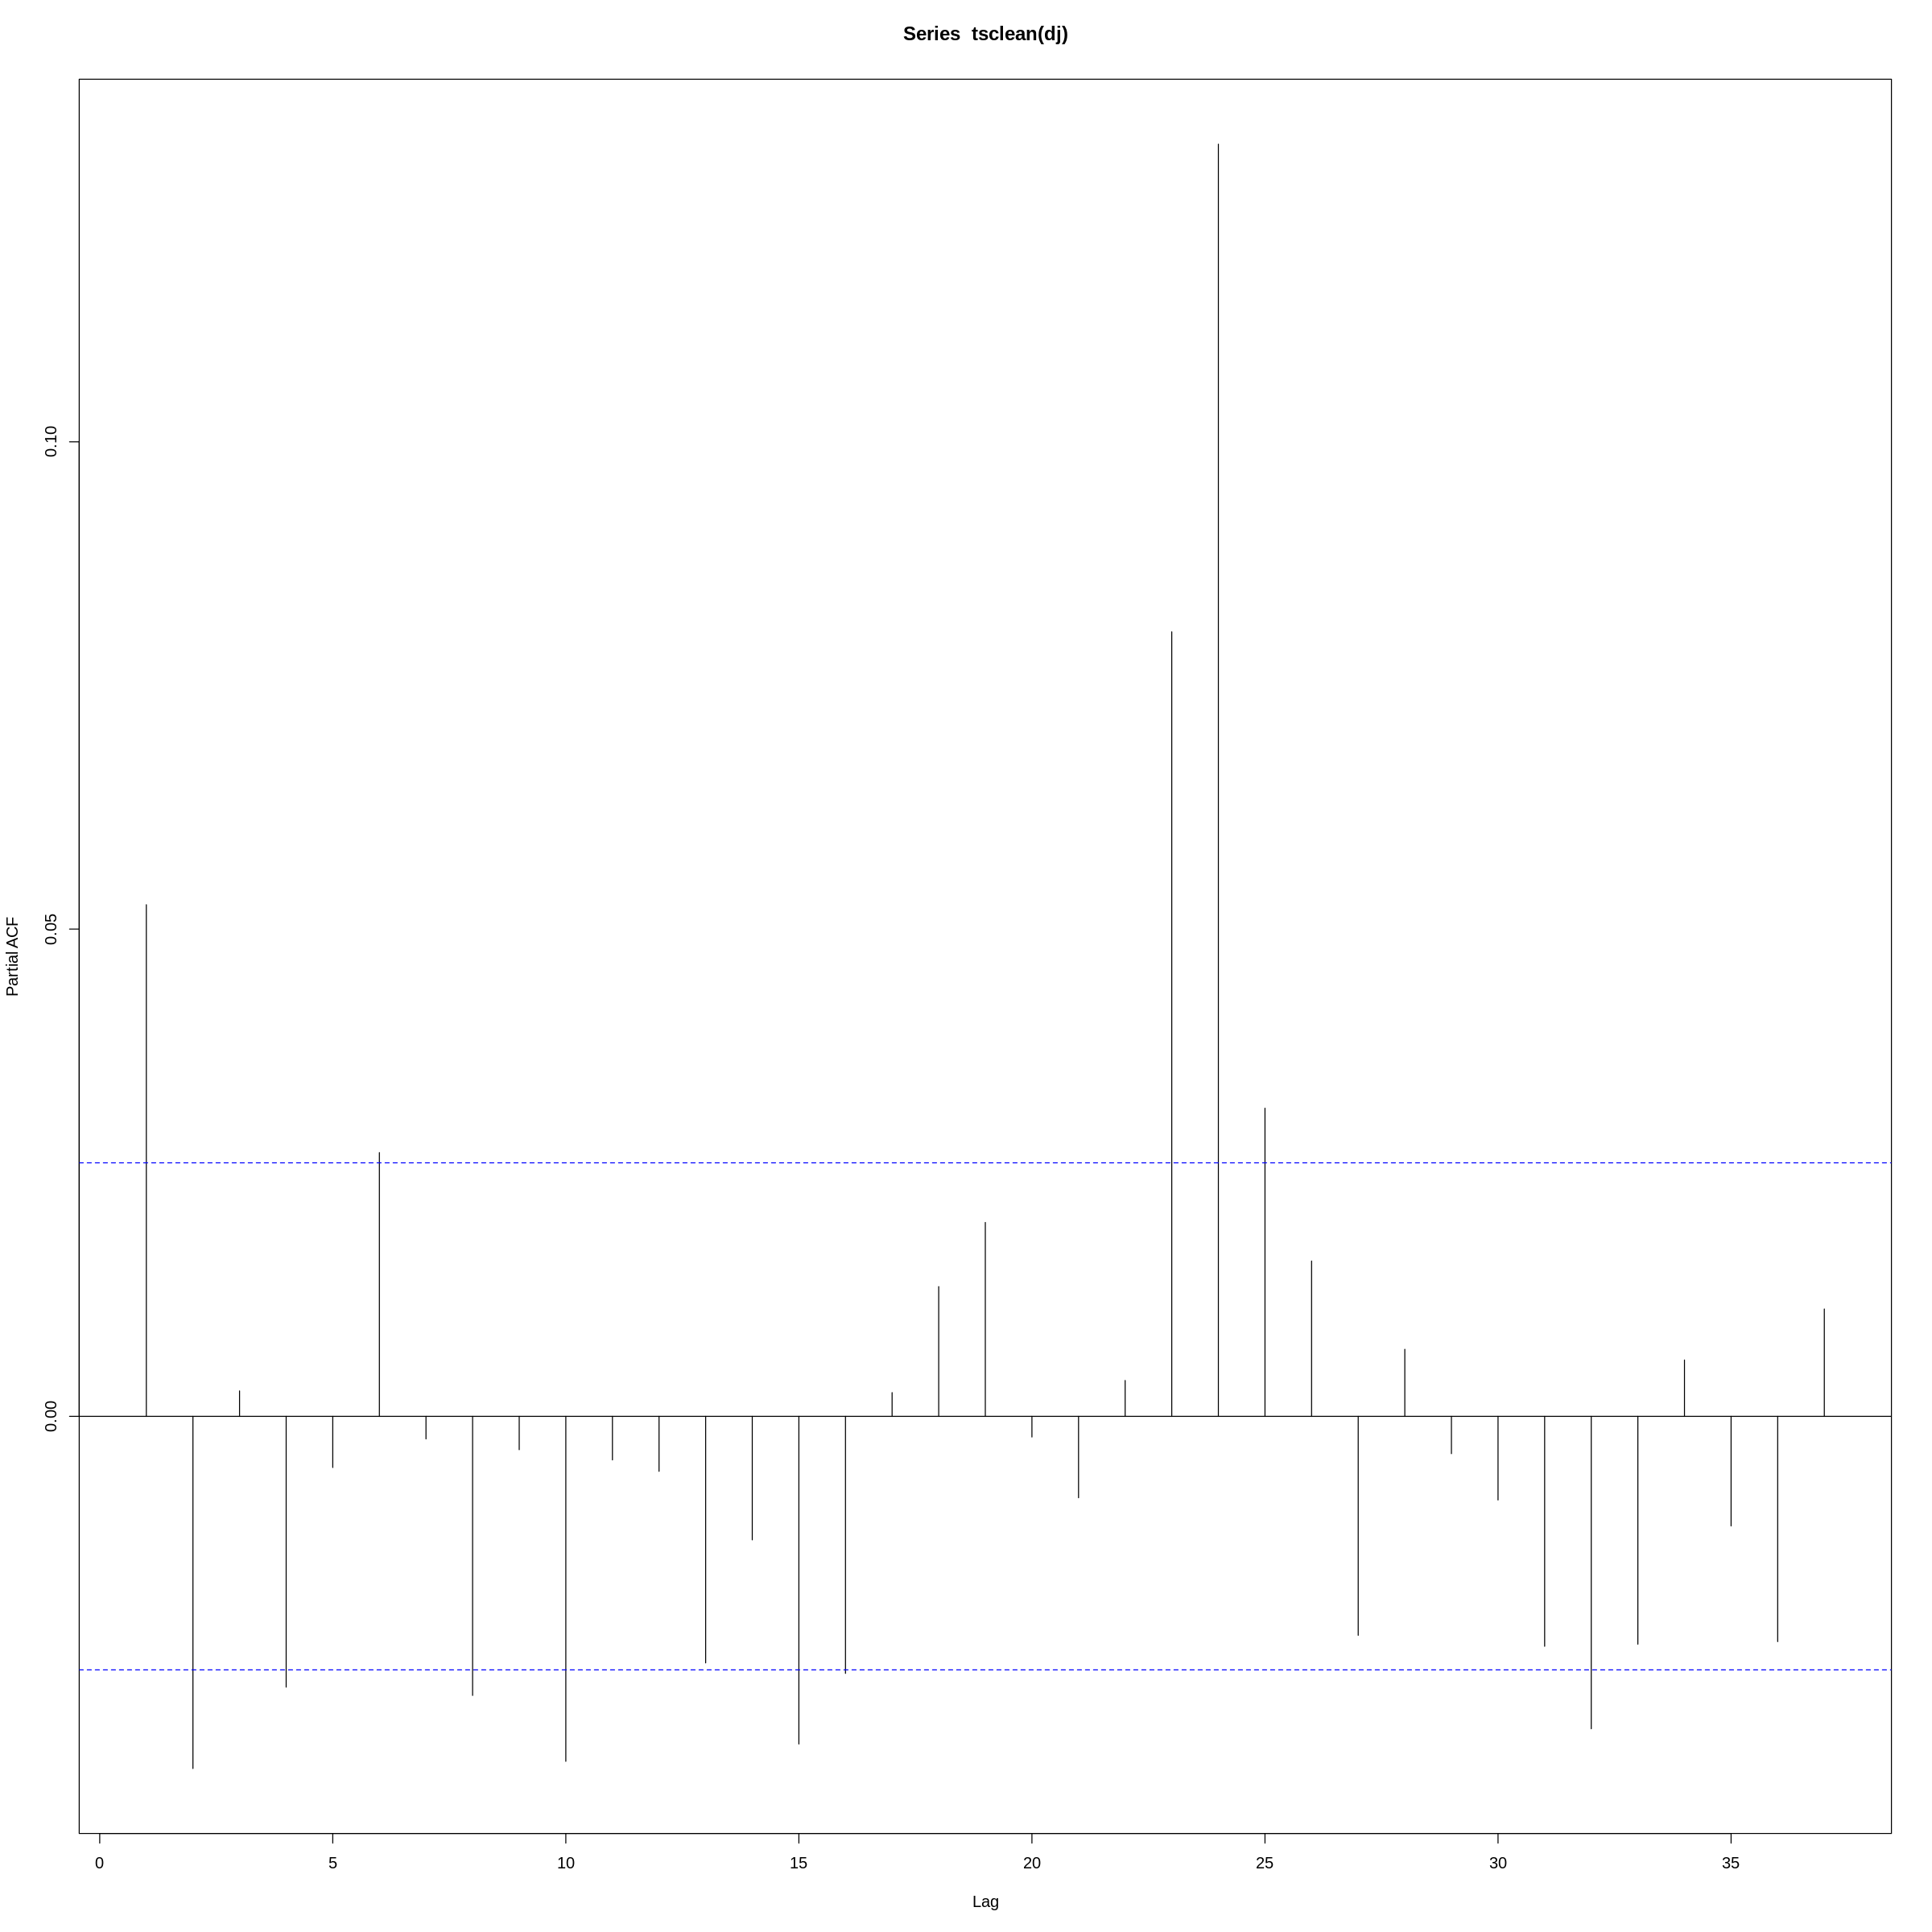

In [501]:
acf(tsclean(dj))
pacf(tsclean(dj))

Most probable models based on the ACF and PACF are ma(4), ar(2) or ar(4), sma(24, 48, ...), sar(24, 48, ...) along with a differentiation term.

auto.arima is trained on the time series

In [502]:
auto <- auto.arima(ltrain)
summary(auto)

Series: ltrain 
ARIMA(5,1,2) 

Coefficients:
         ar1      ar2     ar3      ar4      ar5      ma1     ma2
      1.4460  -0.4110  0.0173  -0.1020  -0.0553  -1.8748  0.8945
s.e.  0.0169   0.0246  0.0242   0.0238   0.0152   0.0101  0.0121

sigma^2 estimated as 94958:  log likelihood=-39713.17
AIC=79442.34   AICc=79442.36   BIC=79495.32

Training set error measures:
                    ME    RMSE      MAE       MPE     MAPE      MASE
Training set -1.452805 307.931 214.1125 -1.537902 8.553059 0.0756289
                     ACF1
Training set -0.006120889

An extended summary is also provided using the sarima function of astsa package.

initial  value 5.844872 
iter   2 value 5.816562
iter   3 value 5.792290
iter   4 value 5.791500
iter   5 value 5.791461
iter   6 value 5.791434
iter   7 value 5.791429
iter   8 value 5.791359
iter   9 value 5.790061
iter  10 value 5.789551
iter  11 value 5.788432
iter  12 value 5.787646
iter  13 value 5.784521
iter  14 value 5.779698
iter  15 value 5.773731
iter  16 value 5.766872
iter  17 value 5.759426
iter  18 value 5.755350
iter  19 value 5.753834
iter  20 value 5.753344
iter  21 value 5.753322
iter  22 value 5.753306
iter  23 value 5.753300
iter  24 value 5.753298
iter  25 value 5.753297
iter  26 value 5.753297
iter  27 value 5.753296
iter  28 value 5.753294
iter  29 value 5.753289
iter  30 value 5.753275
iter  31 value 5.753244
iter  32 value 5.753192
iter  33 value 5.753180
iter  34 value 5.753160
iter  35 value 5.753149
iter  36 value 5.753131
iter  37 value 5.753130
iter  38 value 5.753130
iter  38 value 5.753129
iter  38 value 5.753129
final  value 5.753129 
converged
initia

$fit

Call:
arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, Q), period = S), 
    xreg = constant, transform.pars = trans, fixed = fixed, optim.control = list(trace = trc, 
        REPORT = 1, reltol = tol))

Coefficients:
         ar1      ar2     ar3      ar4      ar5      ma1     ma2  constant
      1.4397  -0.4037  0.0236  -0.1123  -0.0535  -1.8757  0.8957   -0.2109
s.e.  0.0167   0.0243  0.0239   0.0235   0.0150   0.0100  0.0122    0.7721

sigma^2 estimated as 95014:  log likelihood = -40576.29,  aic = 81170.58

$degrees_of_freedom
[1] 5667

$ttable
         Estimate     SE   t.value p.value
ar1        1.4397 0.0167   86.0494  0.0000
ar2       -0.4037 0.0243  -16.6276  0.0000
ar3        0.0236 0.0239    0.9902  0.3221
ar4       -0.1123 0.0235   -4.7778  0.0000
ar5       -0.0535 0.0150   -3.5671  0.0004
ma1       -1.8757 0.0100 -186.6392  0.0000
ma2        0.8957 0.0122   73.5938  0.0000
constant  -0.2109 0.7721   -0.2731  0.7848

$AIC
[1] 14.30319

$AICc
[1] 1

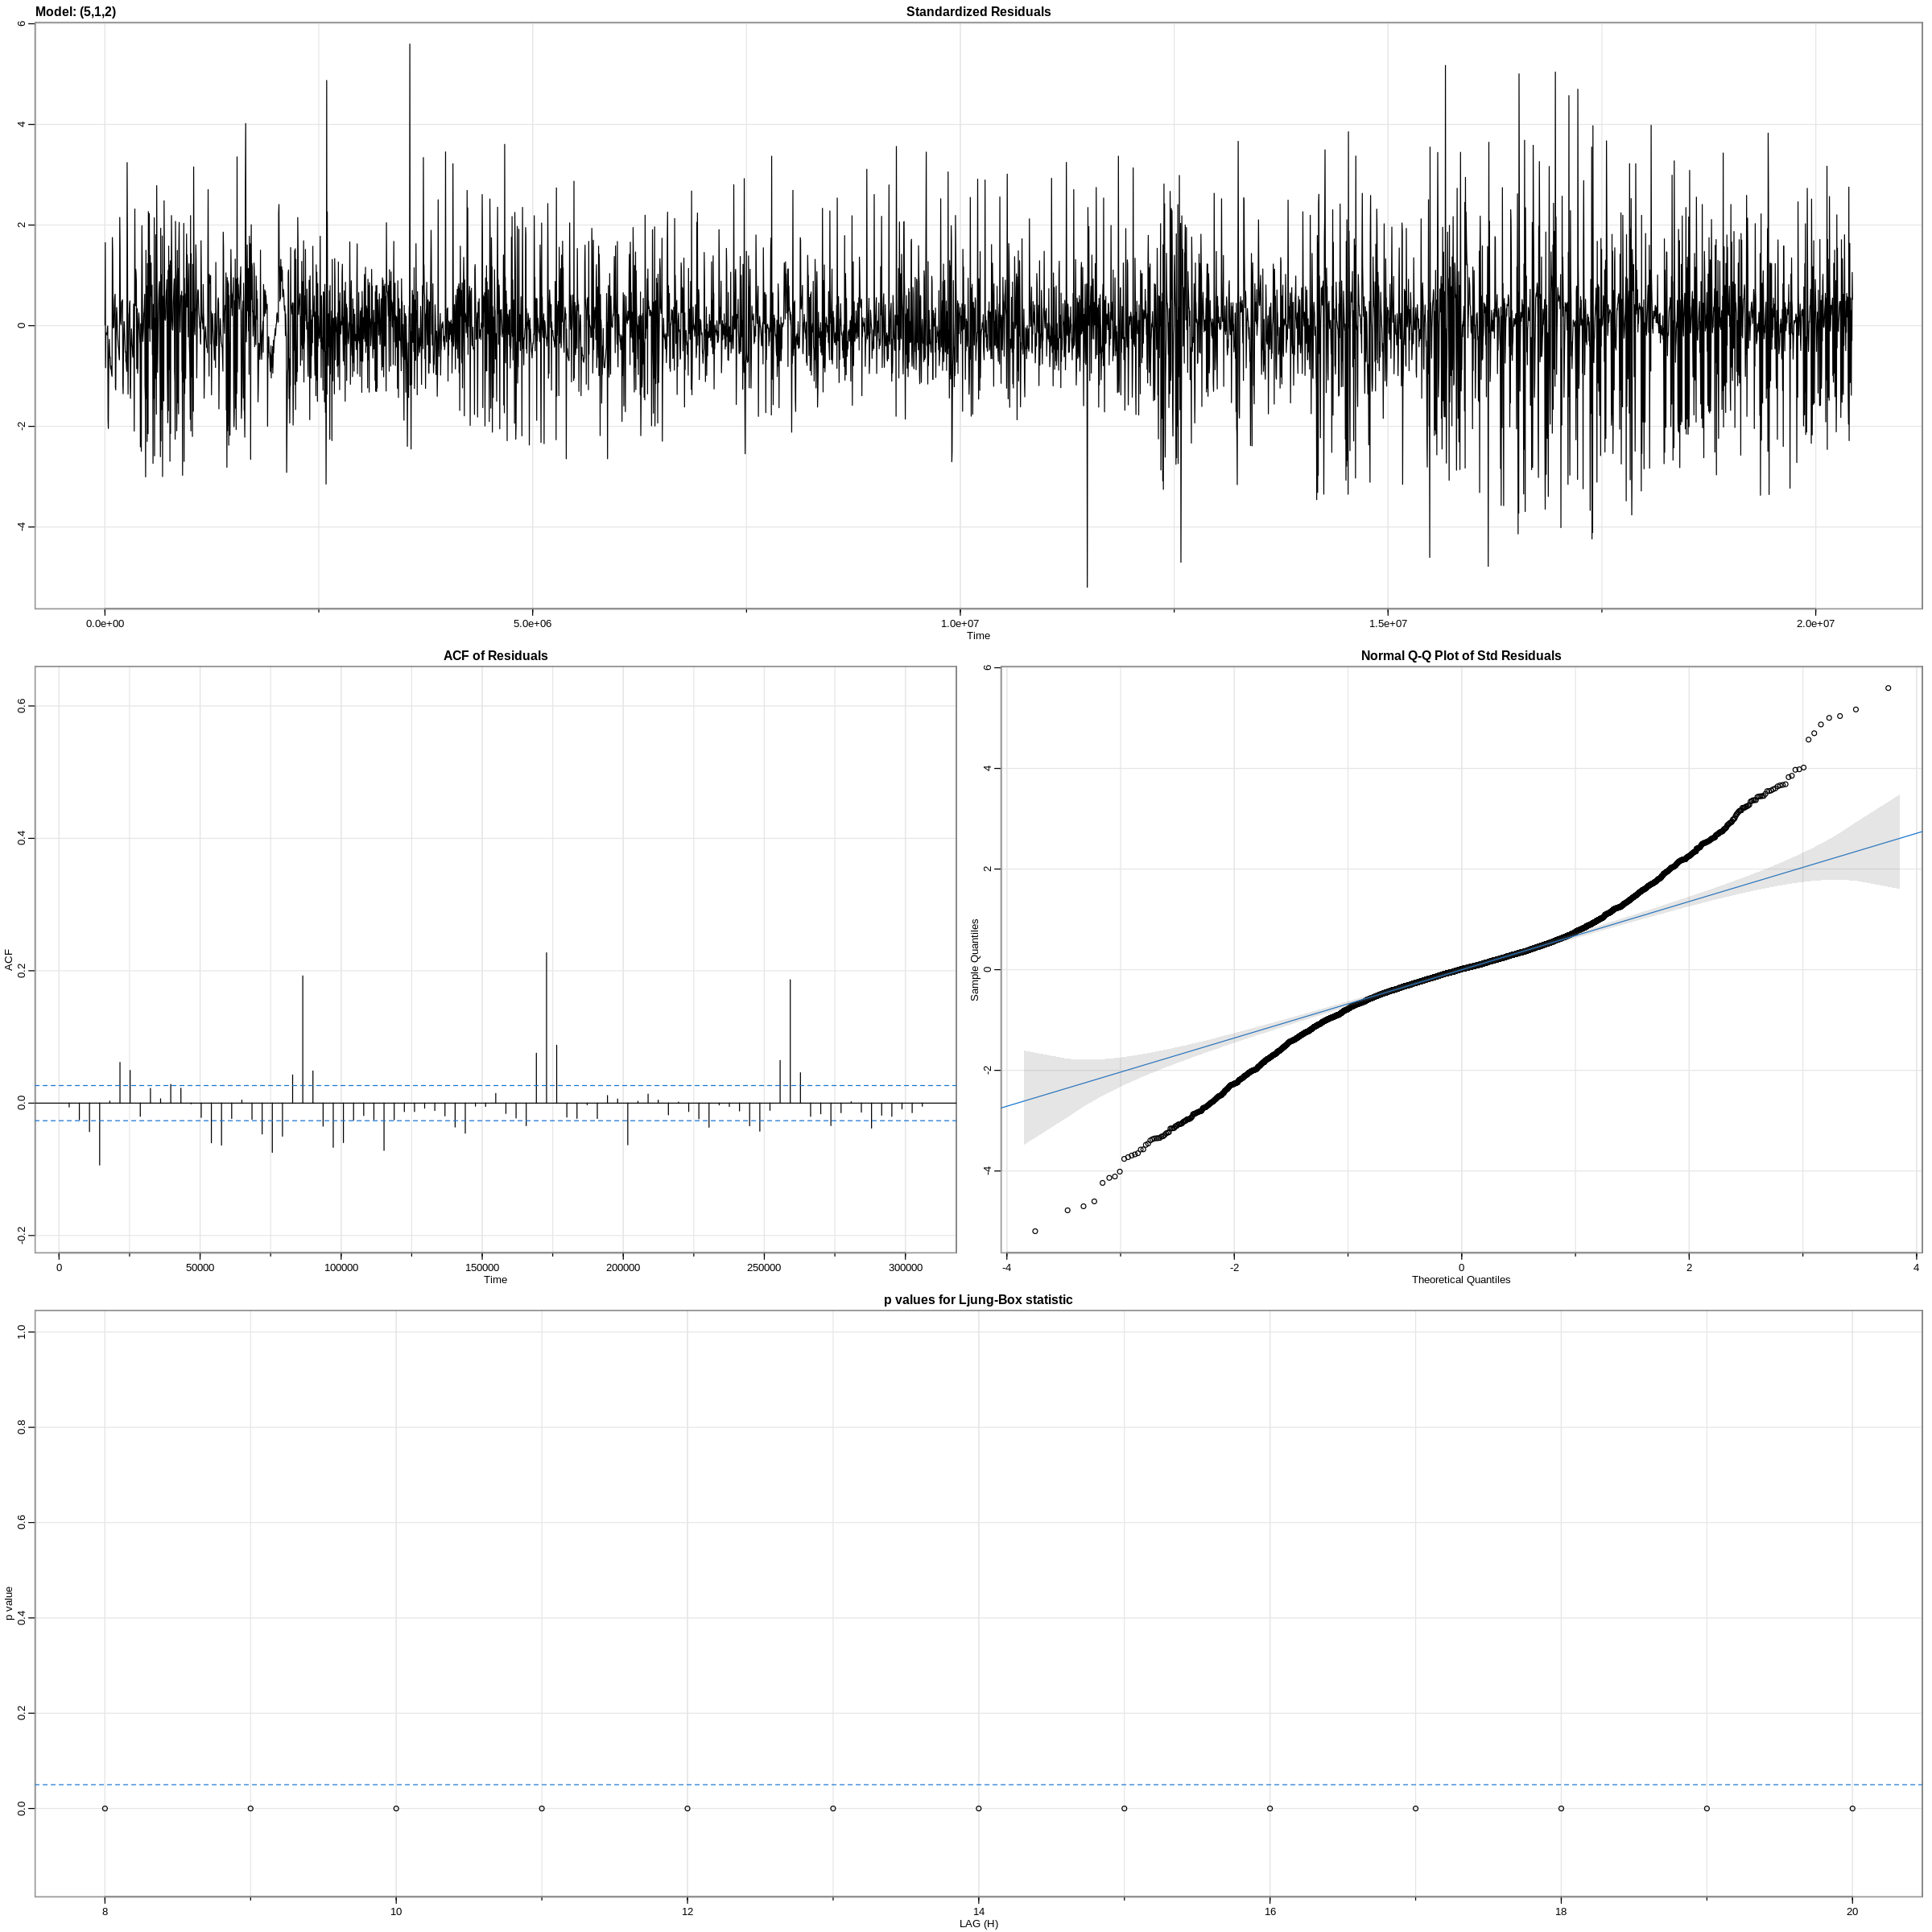

In [503]:
sarima(j, 5, 1, 2, 0, 0, 0)

The model seems to ignore seasonal terms. It also produces systematic residuals. Therfore we proceed to further inspection with gridsearch...

In [474]:
d=1
DD=1
per=24

aics <- c()
c <- 0

for(p in 5:1){
  for(q in 2:1){
    for(i in 5:1){
      for(k in 5:1){
        if(p+d+q+i+DD+k<=20){
          c <- c + 1
          tryCatch({
              
              model <- arima(x=j, order=c((p-1),d,(q-1)), 
                             seasonal=list(order=c((i-1),DD,(k-1)), 
                             period=per))
              pval<-Box.test(model$residuals, lag=log(length(model$residuals)))
              sse<-sum(model$residuals^2)
              cat(c, ". ", p-1,d,q-1,i-1,DD,k-1,per, 'AIC=', model$aic, ', SSE=',sse,', Residual correlation p-VALUE=', pval$p.value,'\n')
              aics <- c(aics, model$aic)
              
              }, error = function(e) {cat(c, ". ", p-1,d,q-1,i-1,DD,k-1,per, 'Failed!\n')
                                      aics <- c(aics, 1000000000)})

        }
      }
    }
  }
}
cat('Minimum AIC: ', min(aics), "\nModel id: ", which.min(aics))

1 .  4 1 1 4 1 4 24 Failed!
2 .  4 1 1 4 1 3 24 Failed!
3 .  4 1 1 4 1 2 24 Failed!
4 .  4 1 1 4 1 1 24 Failed!
5 .  4 1 1 4 1 0 24 Failed!
6 .  4 1 1 3 1 4 24 Failed!
7 .  4 1 1 3 1 3 24 Failed!
8 .  4 1 1 3 1 2 24 Failed!
9 .  4 1 1 3 1 1 24 Failed!
10 .  4 1 1 3 1 0 24 Failed!
11 .  4 1 1 2 1 4 24 AIC= 79776.02  SSE= 442053795 Residual correlation p-VALUE= 0.08616061 


Warning message in log(s2):
“NaNs produced”
Warning message in log(s2):
“NaNs produced”


12 .  4 1 1 2 1 3 24 AIC= 79780.17  SSE= 442537074 Residual correlation p-VALUE= 0.04313842 
13 .  4 1 1 2 1 2 24 AIC= 79791.39  SSE= 443616494 Residual correlation p-VALUE= 0.09146054 
14 .  4 1 1 2 1 1 24 AIC= 79771.91  SSE= 442175939 Residual correlation p-VALUE= 0.07303223 
15 .  4 1 1 2 1 0 24 AIC= 80775.85  SSE= 531240186 Residual correlation p-VALUE= 0.0106738 
16 .  4 1 1 1 1 4 24 AIC= 79775.09  SSE= 442106412 Residual correlation p-VALUE= 0.07545546 
17 .  4 1 1 1 1 3 24 AIC= 79773.34  SSE= 442122508 Residual correlation p-VALUE= 0.07232922 
18 .  4 1 1 1 1 2 24 AIC= 79776.18  SSE= 442489728 Residual correlation p-VALUE= 0.07423786 
19 .  4 1 1 1 1 1 24 AIC= 79787.84  SSE= 443636652 Residual correlation p-VALUE= 0.09110757 
20 .  4 1 1 1 1 0 24 AIC= 81238.05  SSE= 576557961 Residual correlation p-VALUE= 7.335907e-08 
21 .  4 1 1 0 1 4 24 AIC= 79773.12  SSE= 442106064 Residual correlation p-VALUE= 0.07367458 
22 .  4 1 1 0 1 3 24 AIC= 79772.85  SSE= 442256329 Residual correlati

Warning message in log(s2):
“NaNs produced”


136 .  2 1 0 2 1 4 24 AIC= 80294.83  SSE= 485091188 Residual correlation p-VALUE= 0 
137 .  2 1 0 2 1 3 24 AIC= 80301.31  SSE= 485832342 Residual correlation p-VALUE= 0 
138 .  2 1 0 2 1 2 24 AIC= 80297.97  SSE= 485705942 Residual correlation p-VALUE= 0 
139 .  2 1 0 2 1 1 24 AIC= 80296.67  SSE= 485795898 Residual correlation p-VALUE= 0 
140 .  2 1 0 2 1 0 24 AIC= 81315.16  SSE= 585178006 Residual correlation p-VALUE= 0 
141 .  2 1 0 1 1 4 24 AIC= 80299.5  SSE= 485692098 Residual correlation p-VALUE= 0 
142 .  2 1 0 1 1 3 24 AIC= 80298  SSE= 485736302 Residual correlation p-VALUE= 0 
143 .  2 1 0 1 1 2 24 AIC= 80299.37  SSE= 485991417 Residual correlation p-VALUE= 0 
144 .  2 1 0 1 1 1 24 AIC= 80310.6  SSE= 487239323 Residual correlation p-VALUE= 0 
145 .  2 1 0 1 1 0 24 AIC= 81831.93  SSE= 641942907 Residual correlation p-VALUE= 0 
146 .  2 1 0 0 1 4 24 AIC= 80297.58  SSE= 485694554 Residual correlation p-VALUE= 0 
147 .  2 1 0 0 1 3 24 AIC= 80297.58  SSE= 485888443 Residual correlati

Minimum AIC:  79771.91 
Model id:  4

#### Extensive residual summary of the best model:

initial  value 6.082069 
iter   2 value 5.825058
iter   3 value 5.777033
iter   4 value 5.725484
iter   5 value 5.701010
iter   6 value 5.679264
iter   7 value 5.674947
iter   8 value 5.671439
iter   9 value 5.670630
iter  10 value 5.670205
iter  11 value 5.668977
iter  12 value 5.666043
iter  13 value 5.663569
iter  14 value 5.662008
iter  15 value 5.661404
iter  16 value 5.659918
iter  17 value 5.656359
iter  18 value 5.651307
iter  19 value 5.650781
iter  20 value 5.649483
iter  21 value 5.645729
iter  22 value 5.644566
iter  23 value 5.644475
iter  24 value 5.644449
iter  25 value 5.644414
iter  26 value 5.644332
iter  27 value 5.644151
iter  28 value 5.643847
iter  29 value 5.643467
iter  30 value 5.643188
iter  31 value 5.643134
iter  32 value 5.643110
iter  33 value 5.643098
iter  34 value 5.643095
iter  35 value 5.643094
iter  36 value 5.643094
iter  37 value 5.643093
iter  38 value 5.643090
iter  39 value 5.643067
iter  40 value 5.643027
iter  41 value 5.642991
iter  42 value 

Warning message in log(s2):
“NaNs produced”


iter  16 value 5.639349
iter  17 value 5.639341
iter  18 value 5.639325
iter  19 value 5.639208
iter  20 value 5.638715
iter  21 value 5.638389
iter  22 value 5.638352
iter  23 value 5.638327
iter  24 value 5.638300
iter  25 value 5.638288
iter  26 value 5.638251
iter  27 value 5.638220
iter  28 value 5.638094


Warning message in log(s2):
“NaNs produced”


iter  29 value 5.638075
iter  30 value 5.638063
iter  31 value 5.638058
iter  31 value 5.638087
final  value 5.638058 
converged


Warning message in sqrt(diag(fitit$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(fitit$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(x$var.coef)):
“NaNs produced”


$fit

Call:
arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, Q), period = S), 
    include.mean = !no.constant, transform.pars = trans, fixed = fixed, optim.control = list(trace = trc, 
        REPORT = 1, reltol = tol))

Coefficients:
        ar1     ar2     ar3      ar4      ma1    sar1     sar2     sma1    sma2
      0.412  0.1183  0.1096  -0.0492  -0.9634  0.0588  -0.1952  -0.9216  0.2515
s.e.    NaN  0.0028  0.0050      NaN   0.0046     NaN      NaN   0.0077     NaN
         sma3
      -0.2309
s.e.      NaN

sigma^2 estimated as 78311:  log likelihood = -39879.09,  aic = 79780.17

$degrees_of_freedom
[1] 5641

$ttable
     Estimate     SE   t.value p.value
ar1    0.4120    NaN       NaN     NaN
ar2    0.1183 0.0028   42.2663       0
ar3    0.1096 0.0050   22.1129       0
ar4   -0.0492    NaN       NaN     NaN
ma1   -0.9634 0.0046 -209.9870       0
sar1   0.0588    NaN       NaN     NaN
sar2  -0.1952    NaN       NaN     NaN
sma1  -0.9216 0.0077 -119.2355       

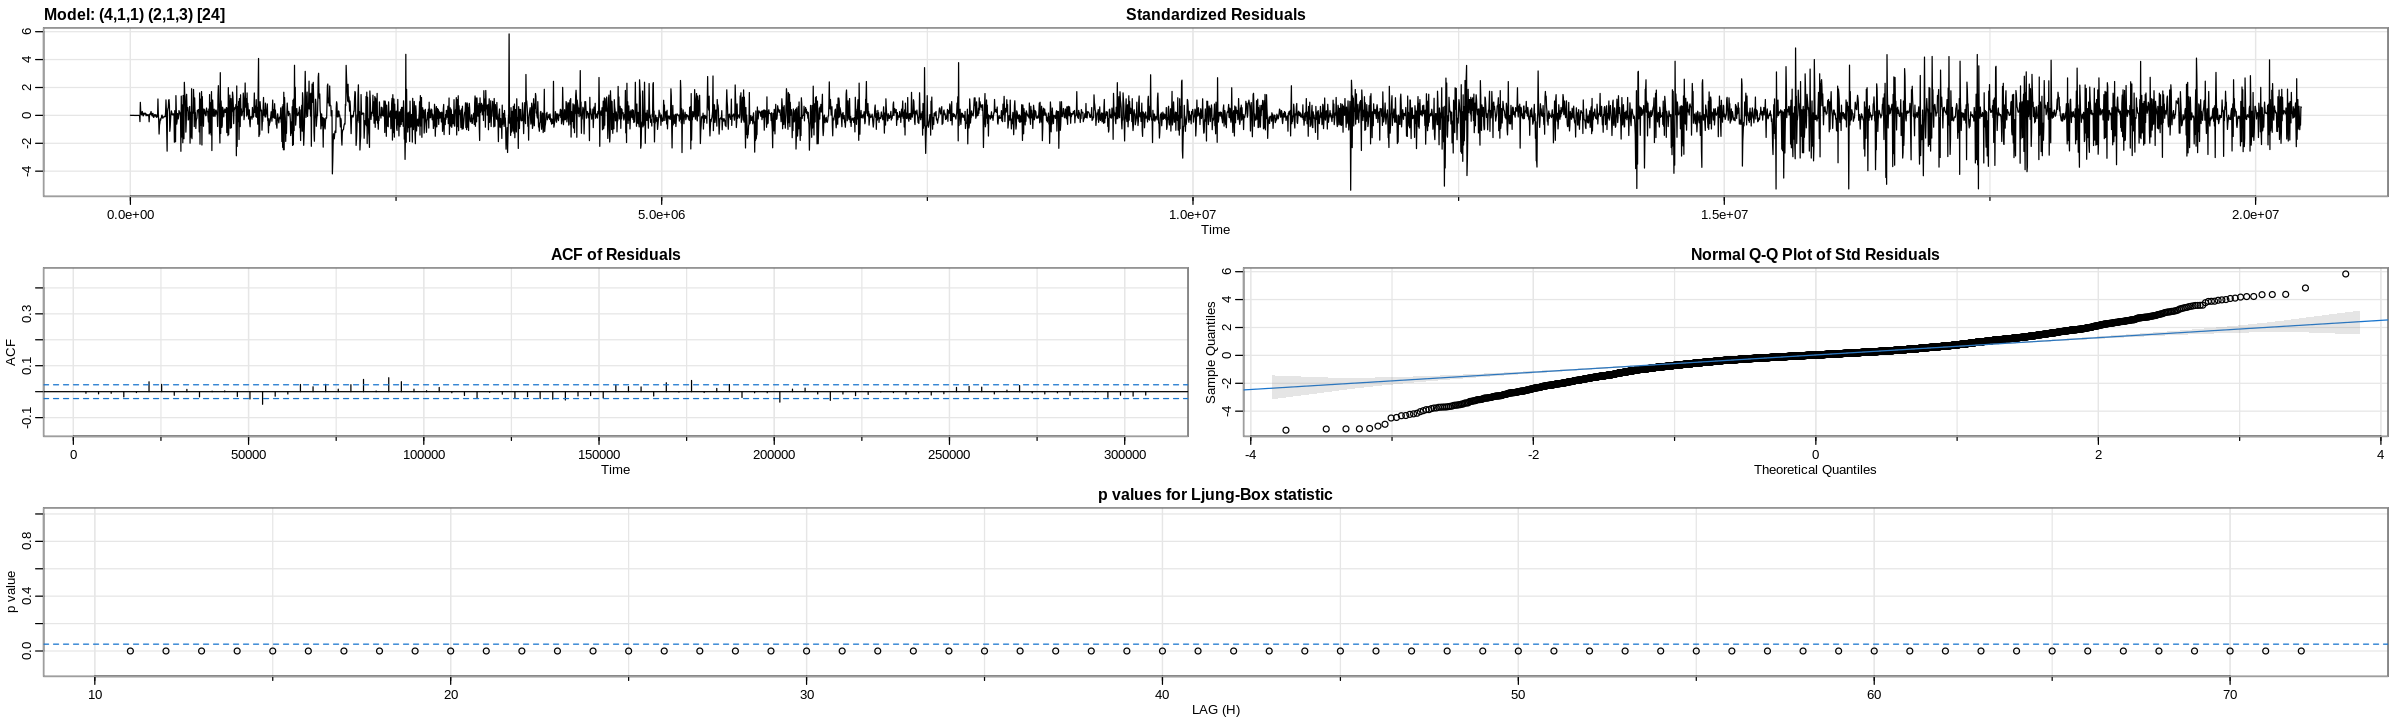

In [476]:
sarima(j, 4, 1, 1, 2, 1, 3, 24)

Residuals still demonstrate systematic patterns while their variance seems to have some volatility especially at the sides of the diagram. Furthermore p-values are marginal that is a bit higher than 0.05. In any case this is the best arima model and will be used for forecasting as well. The auto.arima selected model is ignored (despite of the lower AIC value) as it is clear from the residual ACF that correlations are much bigger than the almost insignificant ones of this particular seasonal model.

# Final observations
1. We need to take into account that despite the yearly seasonality we do not posess data of a whole year and therefore we cannot model this pattern. This seems to somehow confuse the models.
2. Best sarima model is used in python to produce forecasts and evaluate them.